# Import

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import math
import csv

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For Progress Bar
from tqdm import tqdm

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read Data

In [2]:
path = '/kaggle/input/godaddy-microbusiness-density-forecasting/'
data_train  = pd.read_csv(os.path.join(path, 'train.csv'))
data_test = pd.read_csv(os.path.join(path, 'test.csv'))
data_sub = pd.read_csv(os.path.join(path, 'sample_submission.csv'), index_col='row_id')
data_census = pd.read_csv(os.path.join(path, 'census_starter.csv'))

In [3]:
data_train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


# Function for data preprocessing

In [4]:
def split_date(df, drop=False): # split date to year and month
    col_name = df.columns.tolist()
    
    # 加入year, month
    col_name.insert(col_name.index('first_day_of_month')+1,'year')
    col_name.insert(col_name.index('year')+1,'month')
    df = df.reindex(columns=col_name)
    
    year = []
    month = []
    for i in range(len(df)):
        year.append(int(df['first_day_of_month'][i].split('-')[0]))
        month.append(int(df['first_day_of_month'][i].split('-')[1]))
    df['year'] = year
    df['month'] = month
    
    if drop:
        df.drop('first_day_of_month', axis=1, inplace=True)
        
    return df

def change_order(df, name1, name2):
    col_name = df.columns.tolist()
    id1, id2 = col_name.index(name1), col_name.index(name2)
    col_name[id1], col_name[id2] = col_name[id2], col_name[id1]
    df = df.reindex(columns=col_name)
    
    return df

def change_target_order(df, target):
    col_name = df.columns.tolist()
    if col_name[-1] == target:
        return df
    else:
        temp = col_name[-1]
        col_name[-1] = col_name[col_name.index(target)]
        col_name[col_name.index(target)] = temp
        df = df.reindex(columns=col_name)
    
    return df

def target_encoding(df, feature, target, drop=False): # There are too many features, so use target encoding, instead of one-hot-encoding
    name = list(df[feature].unique())
    mean = []
    for n in name:
        mean.append(df[df[feature] == n][target].mean())
    dic = zip(name, mean)
    dic = dict(dic)
    
    col_name = df.columns.tolist()
    col_name.insert(col_name.index(feature)+1, feature + '_mean')
    df = df.reindex(columns=col_name)
    
    mean_list = []
    for i in range(len(df)):
        mean_list.append(dic[df[feature][i]])
    df[feature + '_mean'] = mean_list
    
    if drop:
        df.drop(feature, axis=1, inplace=True)
    
    return df, dic
        

def min_max_scaling(df, name): # feature scaling
    min_value = df[name].min()
    max_value = df[name].max()
    
    new_list = []
    
    for i in range(len(df)):
        new_list.append((df[name][i] - min_value) / (max_value - min_value))
    df[name] = new_list
    return df

def other_scaling(df, name): # Training data and Testing data have different scale, so unify it
    if name == 'year': 
        min_value = 2019
        max_value = 2023
    elif name == 'time':
        min_value = 1
        max_value = 47
    elif name == 'active':
        min_value = 0
        max_value = 1167744
        
    
    df_copy = df.copy()
    new_list = []
    
    for i in range(len(df_copy)):
        new_list.append((df_copy[name][i] - min_value) / (max_value - min_value))
    df_copy[name] = new_list
    return df_copy
    

def time_feature(df, drop=False): # add time fature
    time = []
    time_dict = {2019:-7, 2020:5, 2021:17, 2022:29, 2023:41}
    for t in df[['year', 'month']].values:
        time.append(time_dict[t[0]] + t[1])
    df['time'] = time
    if drop:
        df.drop('year', axis=1, inplace=True)
        df.drop('month', axis=1, inplace=True)
    return df


def take_census(df, drop=False): # take the data of the previous two years
    pct_bb = []
    pct_college = []
    pct_foreign_born = []
    pct_it_workers = []
    median_hh_inc = []
    for i, year in enumerate(df['year'].values):
        year -= 2
        
        pct_bb.append(df['pct_bb_{}'.format(year)][i])
        pct_college.append(df['pct_college_{}'.format(year)][i])
        pct_foreign_born.append(df['pct_foreign_born_{}'.format(year)][i])
        pct_it_workers.append(df['pct_it_workers_{}'.format(year)][i])
        median_hh_inc.append(df['median_hh_inc_{}'.format(year)][i])
    
    df['pct_bb'] = pct_bb
    df['pct_college'] = pct_college
    df['pct_foreign_born'] = pct_foreign_born
    df['pct_it_workers'] = pct_it_workers
    df['median_hh_inc'] = median_hh_inc
    
    if drop:
        for i in range(2017, 2022):
            df.drop('pct_bb_{}'.format(i), axis=1, inplace=True)
            df.drop('pct_college_{}'.format(i), axis=1, inplace=True)
            df.drop('pct_foreign_born_{}'.format(i), axis=1, inplace=True)
            df.drop('pct_it_workers_{}'.format(i), axis=1, inplace=True)
            df.drop('median_hh_inc_{}'.format(i), axis=1, inplace=True)
                
    return df

def get_county_code(df): # Give each data an unique county code
    county = []
    for i in range(len(df)):
        county.append(county_dict[df['cfips'][i]])
    df['county_code'] = county

# Data Preprocessing

## Training Data

In [5]:
# split to year and month
data_train = split_date(data_train, drop=True)

In [6]:
county_list = []
for i in range(len(data_train)):
    county_list.append(data_train['county'][i].split(' ')[0])
data_train['county'] = county_list
data_train

,row_id,cfips,county,state,year,month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga,Alabama,2019,8,3.007682,1249
1,1001_2019-09-01,1001,Autauga,Alabama,2019,9,2.884870,1198
2,1001_2019-10-01,1001,Autauga,Alabama,2019,10,3.055843,1269
3,1001_2019-11-01,1001,Autauga,Alabama,2019,11,2.993233,1243
4,1001_2019-12-01,1001,Autauga,Alabama,2019,12,2.993233,1243
...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston,Wyoming,2022,6,1.803249,101
122261,56045_2022-07-01,56045,Weston,Wyoming,2022,7,1.803249,101
122262,56045_2022-08-01,56045,Weston,Wyoming,2022,8,1.785395,100
122263,56045_2022-09-01,56045,Weston,Wyoming,2022,9,1.785395,100


In [7]:
# Get county_code
county_name = list(data_train['cfips'].unique())
county_code = []
for i in range(len(data_train['cfips'].unique())):
    county_code.append(i)
county_dict = zip(county_name, county_code)
county_dict = dict(county_dict)


get_county_code(data_train)
data_train

,row_id,cfips,county,state,year,month,microbusiness_density,active,county_code
0,1001_2019-08-01,1001,Autauga,Alabama,2019,8,3.007682,1249,0
1,1001_2019-09-01,1001,Autauga,Alabama,2019,9,2.884870,1198,0
2,1001_2019-10-01,1001,Autauga,Alabama,2019,10,3.055843,1269,0
3,1001_2019-11-01,1001,Autauga,Alabama,2019,11,2.993233,1243,0
4,1001_2019-12-01,1001,Autauga,Alabama,2019,12,2.993233,1243,0
...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston,Wyoming,2022,6,1.803249,101,3134
122261,56045_2022-07-01,56045,Weston,Wyoming,2022,7,1.803249,101,3134
122262,56045_2022-08-01,56045,Weston,Wyoming,2022,8,1.785395,100,3134
122263,56045_2022-09-01,56045,Weston,Wyoming,2022,9,1.785395,100,3134


In [8]:
# traget encoding
data_train, s_dic = target_encoding(data_train, feature='state', target='microbusiness_density', drop=True)
data_train, c_dic = target_encoding(data_train, feature='county_code', target='microbusiness_density', drop=False)
# add time feature
data_train = time_feature(data_train, drop=False)

data_train = change_target_order(data_train, target='microbusiness_density')
data_train.drop('county', axis=1, inplace=True)
data_train

,row_id,cfips,state_mean,year,month,time,active,county_code,county_code_mean,microbusiness_density
0,1001_2019-08-01,1001,2.223274,2019,8,1,1249,0,3.164535,3.007682
1,1001_2019-09-01,1001,2.223274,2019,9,2,1198,0,3.164535,2.884870
2,1001_2019-10-01,1001,2.223274,2019,10,3,1269,0,3.164535,3.055843
3,1001_2019-11-01,1001,2.223274,2019,11,4,1243,0,3.164535,2.993233
4,1001_2019-12-01,1001,2.223274,2019,12,5,1243,0,3.164535,2.993233
...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,9.036705,2022,6,35,101,3134,1.663503,1.803249
122261,56045_2022-07-01,56045,9.036705,2022,7,36,101,3134,1.663503,1.803249
122262,56045_2022-08-01,56045,9.036705,2022,8,37,100,3134,1.663503,1.785395
122263,56045_2022-09-01,56045,9.036705,2022,9,38,100,3134,1.663503,1.785395


In [9]:
data_census

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,82.2,82.4,84.0,86.7,88.4,56037,15.3,15.2,14.8,13.7,...,0.6,0.6,1.0,0.9,1.0,71083,73008.0,74843,73384.0,76668.0
3138,83.5,85.9,87.1,89.1,90.5,56039,37.7,37.8,38.9,37.2,...,0.7,1.2,1.4,1.5,2.0,80049,83831.0,84678,87053.0,94498.0
3139,83.8,88.2,89.5,91.4,90.6,56041,11.9,10.5,11.1,12.6,...,1.2,1.2,1.4,1.7,0.9,54672,58235.0,63403,72458.0,75106.0
3140,76.4,78.3,78.2,82.8,85.4,56043,15.4,15.0,15.4,15.0,...,1.3,1.0,0.9,0.9,1.1,51362,53426.0,54158,57306.0,62271.0


In [10]:
data_census.isna().sum()

pct_bb_2017              0
pct_bb_2018              0
pct_bb_2019              0
pct_bb_2020              1
pct_bb_2021              1
cfips                    0
pct_college_2017         0
pct_college_2018         0
pct_college_2019         0
pct_college_2020         1
pct_college_2021         1
pct_foreign_born_2017    0
pct_foreign_born_2018    0
pct_foreign_born_2019    0
pct_foreign_born_2020    1
pct_foreign_born_2021    1
pct_it_workers_2017      0
pct_it_workers_2018      1
pct_it_workers_2019      0
pct_it_workers_2020      1
pct_it_workers_2021      1
median_hh_inc_2017       0
median_hh_inc_2018       1
median_hh_inc_2019       0
median_hh_inc_2020       2
median_hh_inc_2021       2
dtype: int64

In [11]:
# fill up missing data
new = data_census.iloc[92].values
new[3], new[4] = 80.3, 80.3
new[9], new[10] = 14.5,12.5
new[14], new[15] = 6.8, 7
new[19], new[20] = 6.3, 7.3
new[24], new[25] = 78500, 77500
data_census.iloc[92] = new

new = data_census.iloc[1816].values
new[17], new[22] = 0.8, 36500
data_census.iloc[1816] = new

new = data_census.iloc[2644].values
new[24] = 45000
data_census.iloc[2644] = new

new = data_census.iloc[2673].values
new[25] = 44000
data_census.iloc[2673] = new

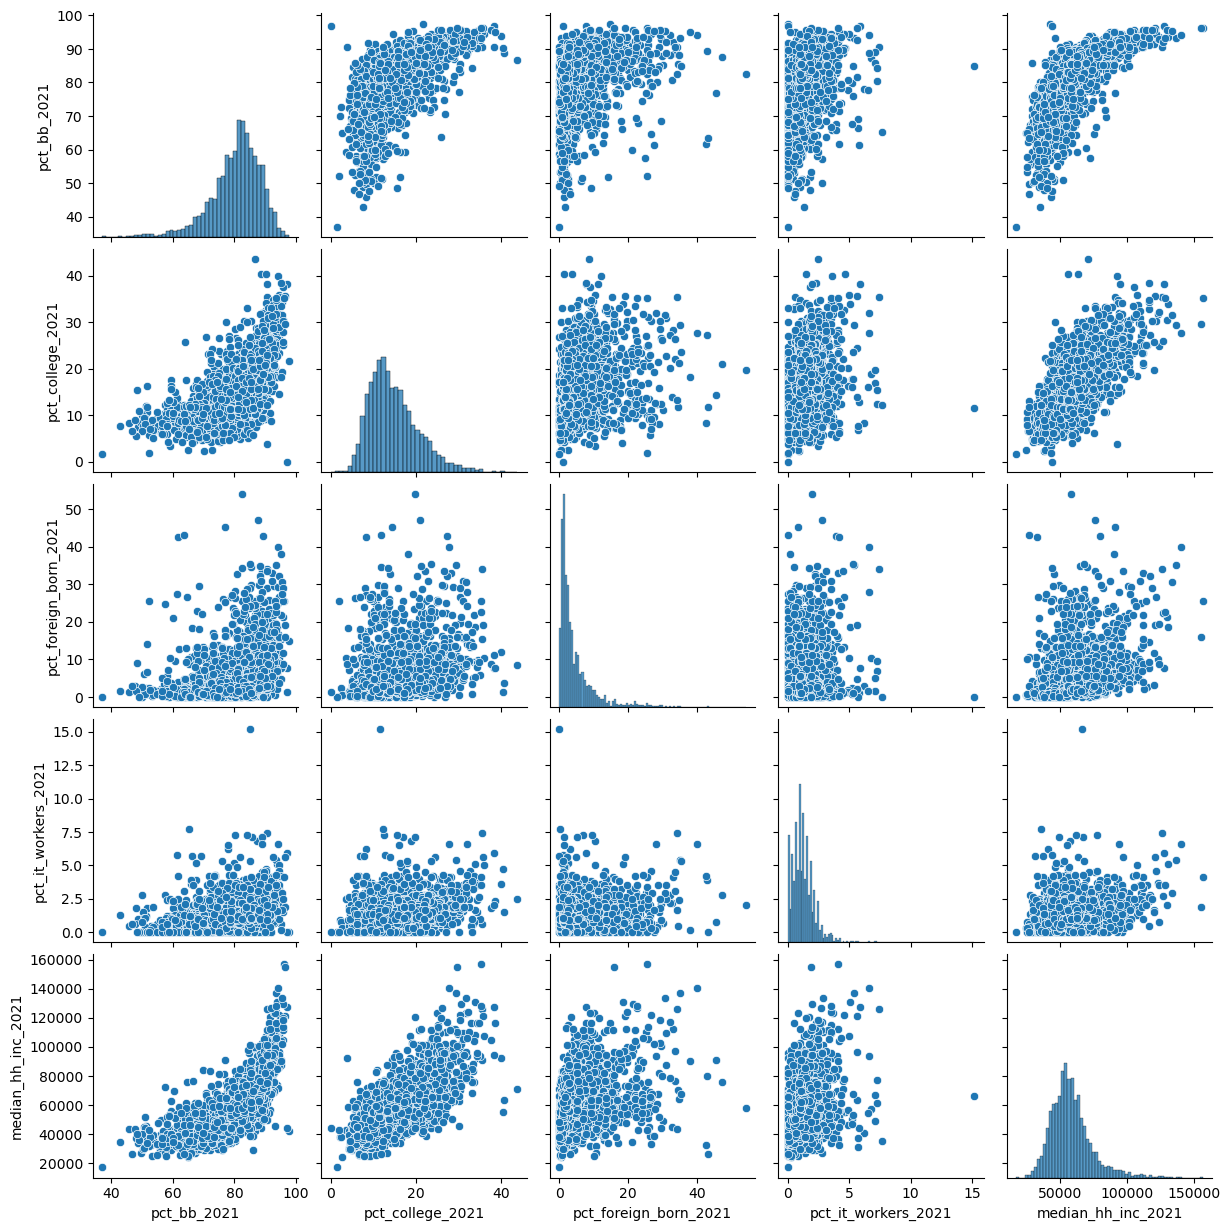

In [12]:
sns.pairplot(data_census[['pct_bb_2021', 'pct_college_2021', 'pct_foreign_born_2021', 'pct_it_workers_2021', 'median_hh_inc_2021']])

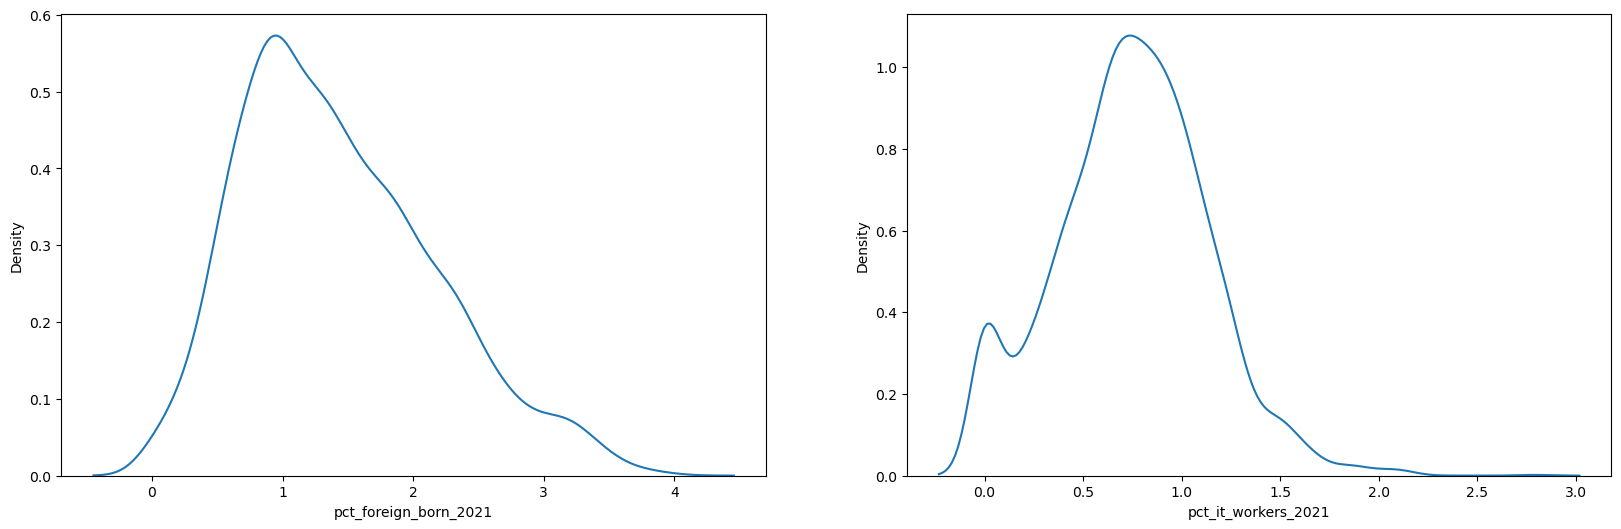

In [13]:
# Are pct_foreign_born and pct_it_workers exponentially distributed?
log_foriegn_born = np.log(data_census.pct_foreign_born_2021+1)
log_it_workers = np.log(data_census.pct_it_workers_2021+1)


plt.figure(figsize = (20,6))

plt.subplot(1,2,1)
sns.kdeplot(log_foriegn_born)

plt.subplot(1,2,2)
sns.kdeplot(log_it_workers)

plt.show()

In [14]:
data_census['pct_foreign_born_2017'] = np.log(data_census['pct_foreign_born_2017'] + 1) 
data_census['pct_foreign_born_2018'] = np.log(data_census['pct_foreign_born_2018'] + 1)
data_census['pct_foreign_born_2019'] = np.log(data_census['pct_foreign_born_2019'] + 1)
data_census['pct_foreign_born_2020'] = np.log(data_census['pct_foreign_born_2020'] + 1)
data_census['pct_foreign_born_2021'] = np.log(data_census['pct_foreign_born_2021'] + 1)

data_census['pct_it_workers_2017'] = np.log(data_census['pct_it_workers_2017'] + 1)
data_census['pct_it_workers_2018'] = np.log(data_census['pct_it_workers_2018'] + 1)
data_census['pct_it_workers_2019'] = np.log(data_census['pct_it_workers_2019'] + 1)
data_census['pct_it_workers_2020'] = np.log(data_census['pct_it_workers_2020'] + 1)
data_census['pct_it_workers_2021'] = np.log(data_census['pct_it_workers_2021'] + 1)

In [15]:
data_census_copy = data_census.copy()

In [16]:
# merge training data and census data
merged_data_train = pd.merge(data_train, data_census, how = 'left', on = 'cfips')
merged_data_train.set_index('row_id',inplace=True)
data_train = merged_data_train
data_train

,cfips,state_mean,year,month,time,active,county_code,county_code_mean,microbusiness_density,pct_bb_2017,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
row_id,,,,,,,,,,,,,,,,,,,,,
1001_2019-08-01,1001,2.223274,2019,8,1,1249,0,3.164535,3.007682,76.6,...,0.832909,0.741937,0.530628,0.470004,0.741937,55317,58786.0,58731,57982.0,62660.0
1001_2019-09-01,1001,2.223274,2019,9,2,1198,0,3.164535,2.884870,76.6,...,0.832909,0.741937,0.530628,0.470004,0.741937,55317,58786.0,58731,57982.0,62660.0
1001_2019-10-01,1001,2.223274,2019,10,3,1269,0,3.164535,3.055843,76.6,...,0.832909,0.741937,0.530628,0.470004,0.741937,55317,58786.0,58731,57982.0,62660.0
1001_2019-11-01,1001,2.223274,2019,11,4,1243,0,3.164535,2.993233,76.6,...,0.832909,0.741937,0.530628,0.470004,0.741937,55317,58786.0,58731,57982.0,62660.0
1001_2019-12-01,1001,2.223274,2019,12,5,1243,0,3.164535,2.993233,76.6,...,0.832909,0.741937,0.530628,0.470004,0.741937,55317,58786.0,58731,57982.0,62660.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56045_2022-06-01,56045,9.036705,2022,6,35,101,3134,1.663503,1.803249,71.1,...,0.470004,0.470004,0.000000,0.000000,0.000000,59605,52867.0,57031,53333.0,65566.0
56045_2022-07-01,56045,9.036705,2022,7,36,101,3134,1.663503,1.803249,71.1,...,0.470004,0.470004,0.000000,0.000000,0.000000,59605,52867.0,57031,53333.0,65566.0
56045_2022-08-01,56045,9.036705,2022,8,37,100,3134,1.663503,1.785395,71.1,...,0.470004,0.470004,0.000000,0.000000,0.000000,59605,52867.0,57031,53333.0,65566.0


In [17]:
# take the data of the previous two years
data_train['pct_bb'] = np.nan
data_train['pct_college'] = np.nan
data_train['pct_foreign_born'] = np.nan
data_train['pct_it_workers'] = np.nan
data_train['median_hh_inc'] = np.nan

data_train = take_census(data_train, drop=True)
data_train

,cfips,state_mean,year,month,time,active,county_code,county_code_mean,microbusiness_density,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc
row_id,,,,,,,,,,,,,,
1001_2019-08-01,1001,2.223274,2019,8,1,1249,0,3.164535,3.007682,76.6,14.5,1.131402,0.832909,55317.0
1001_2019-09-01,1001,2.223274,2019,9,2,1198,0,3.164535,2.884870,76.6,14.5,1.131402,0.832909,55317.0
1001_2019-10-01,1001,2.223274,2019,10,3,1269,0,3.164535,3.055843,76.6,14.5,1.131402,0.832909,55317.0
1001_2019-11-01,1001,2.223274,2019,11,4,1243,0,3.164535,2.993233,76.6,14.5,1.131402,0.832909,55317.0
1001_2019-12-01,1001,2.223274,2019,12,5,1243,0,3.164535,2.993233,76.6,14.5,1.131402,0.832909,55317.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56045_2022-06-01,56045,9.036705,2022,6,35,101,3134,1.663503,1.803249,79.7,12.7,1.193922,0.000000,53333.0
56045_2022-07-01,56045,9.036705,2022,7,36,101,3134,1.663503,1.803249,79.7,12.7,1.193922,0.000000,53333.0
56045_2022-08-01,56045,9.036705,2022,8,37,100,3134,1.663503,1.785395,79.7,12.7,1.193922,0.000000,53333.0


In [18]:
data_train.drop("cfips", axis=1, inplace=True)
data_train = change_target_order(data_train, target='microbusiness_density')

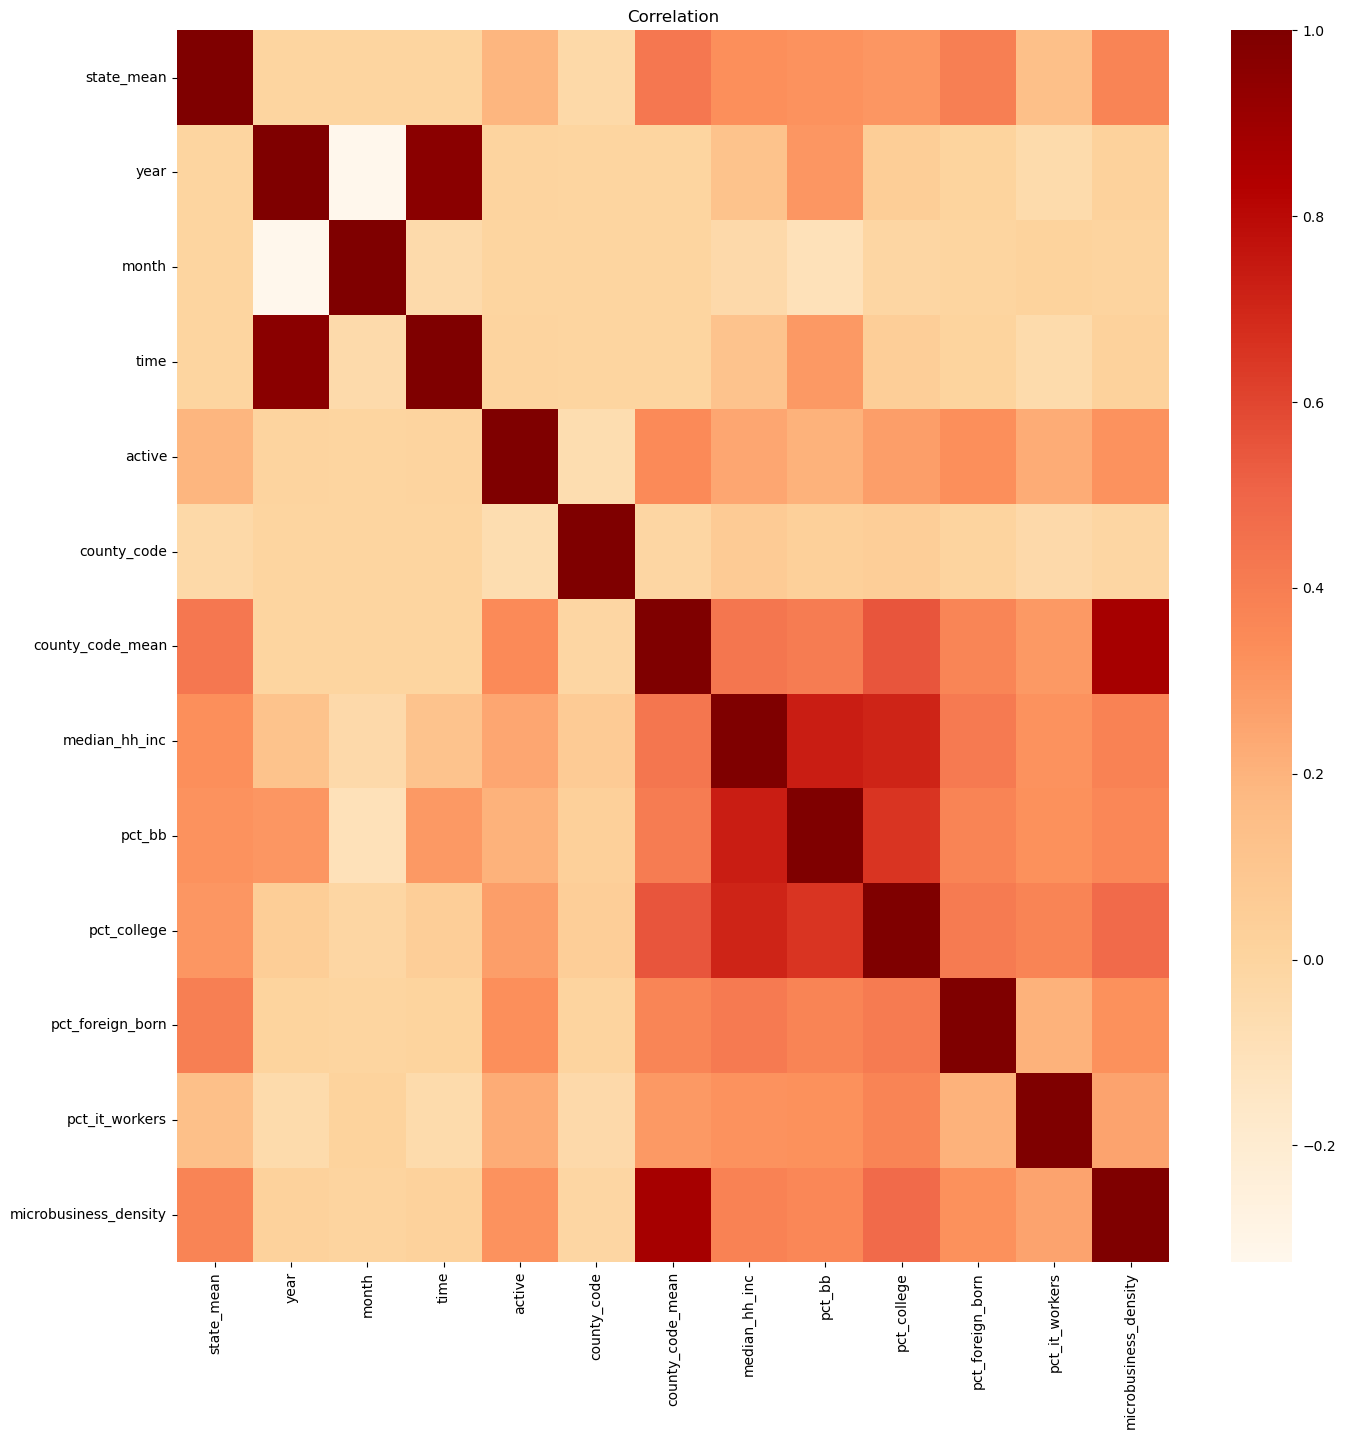

In [19]:
plt.figure(figsize=(16, 16))
sns.heatmap(data_train.corr(), cmap="OrRd")
plt.title('Correlation')
plt.show()

In [20]:
# make same index on training and testing data
col_order = list(data_train.columns.values)
data_train

,state_mean,year,month,time,active,county_code,county_code_mean,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,microbusiness_density
row_id,,,,,,,,,,,,,
1001_2019-08-01,2.223274,2019,8,1,1249,0,3.164535,55317.0,76.6,14.5,1.131402,0.832909,3.007682
1001_2019-09-01,2.223274,2019,9,2,1198,0,3.164535,55317.0,76.6,14.5,1.131402,0.832909,2.884870
1001_2019-10-01,2.223274,2019,10,3,1269,0,3.164535,55317.0,76.6,14.5,1.131402,0.832909,3.055843
1001_2019-11-01,2.223274,2019,11,4,1243,0,3.164535,55317.0,76.6,14.5,1.131402,0.832909,2.993233
1001_2019-12-01,2.223274,2019,12,5,1243,0,3.164535,55317.0,76.6,14.5,1.131402,0.832909,2.993233
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56045_2022-06-01,9.036705,2022,6,35,101,3134,1.663503,53333.0,79.7,12.7,1.193922,0.000000,1.803249
56045_2022-07-01,9.036705,2022,7,36,101,3134,1.663503,53333.0,79.7,12.7,1.193922,0.000000,1.803249
56045_2022-08-01,9.036705,2022,8,37,100,3134,1.663503,53333.0,79.7,12.7,1.193922,0.000000,1.785395


## Testing Data

In [21]:
data_test

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01
...,...,...,...
25075,56037_2023-06-01,56037,2023-06-01
25076,56039_2023-06-01,56039,2023-06-01
25077,56041_2023-06-01,56041,2023-06-01
25078,56043_2023-06-01,56043,2023-06-01


In [22]:
# import some county, state, and cfips data to merge testing data
import requests
url = 'https://raw.githubusercontent.com/ChuckConnell/articles/master/fips2county.tsv'

county_state_cfips_df = pd.read_csv(url, 
                                    delimiter='\t',
                                    header='infer',
                                    usecols=['CountyFIPS', 'CountyName', 'StateName'])

county_state_cfips_df.rename(columns={'CountyFIPS':'cfips', 
                                      'CountyName': 'county',
                                      'StateName':'state'}, inplace=True)

county_state_cfips_df.head()

,county,state,cfips
0,Autauga,Alabama,1001
1,Baldwin,Alabama,1003
2,Barbour,Alabama,1005
3,Bibb,Alabama,1007
4,Blount,Alabama,1009


In [23]:
# merge the test data and county_state_cfips_df
data_test = pd.merge(data_test, county_state_cfips_df, how='left', on='cfips')
data_test

,row_id,cfips,first_day_of_month,county,state
0,1001_2022-11-01,1001,2022-11-01,Autauga,Alabama
1,1003_2022-11-01,1003,2022-11-01,Baldwin,Alabama
2,1005_2022-11-01,1005,2022-11-01,Barbour,Alabama
3,1007_2022-11-01,1007,2022-11-01,Bibb,Alabama
4,1009_2022-11-01,1009,2022-11-01,Blount,Alabama
...,...,...,...,...,...
25075,56037_2023-06-01,56037,2023-06-01,Sweetwater,Wyoming
25076,56039_2023-06-01,56039,2023-06-01,Teton,Wyoming
25077,56041_2023-06-01,56041,2023-06-01,Uinta,Wyoming
25078,56043_2023-06-01,56043,2023-06-01,Washakie,Wyoming


In [24]:
get_county_code(data_test)
data_test

,row_id,cfips,first_day_of_month,county,state,county_code
0,1001_2022-11-01,1001,2022-11-01,Autauga,Alabama,0
1,1003_2022-11-01,1003,2022-11-01,Baldwin,Alabama,1
2,1005_2022-11-01,1005,2022-11-01,Barbour,Alabama,2
3,1007_2022-11-01,1007,2022-11-01,Bibb,Alabama,3
4,1009_2022-11-01,1009,2022-11-01,Blount,Alabama,4
...,...,...,...,...,...,...
25075,56037_2023-06-01,56037,2023-06-01,Sweetwater,Wyoming,3130
25076,56039_2023-06-01,56039,2023-06-01,Teton,Wyoming,3131
25077,56041_2023-06-01,56041,2023-06-01,Uinta,Wyoming,3132
25078,56043_2023-06-01,56043,2023-06-01,Washakie,Wyoming,3133


In [25]:
# merge testing data and census data
merged_data_test = pd.merge(data_test, data_census_copy, how = 'left', on = 'cfips')
data_test = merged_data_test
data_test

,row_id,cfips,first_day_of_month,county,state,county_code,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,1001_2022-11-01,1001,2022-11-01,Autauga,Alabama,0,76.6,78.9,80.6,82.7,...,0.832909,0.741937,0.530628,0.470004,0.741937,55317,58786.0,58731,57982.0,62660.0
1,1003_2022-11-01,1003,2022-11-01,Baldwin,Alabama,1,74.5,78.1,81.8,85.1,...,0.875469,0.832909,0.875469,0.693147,0.832909,52562,55962.0,58320,61756.0,64346.0
2,1005_2022-11-01,1005,2022-11-01,Barbour,Alabama,2,57.2,60.4,60.5,64.6,...,0.405465,0.262364,0.587787,0.741937,0.587787,33368,34186.0,32525,34990.0,36422.0
3,1007_2022-11-01,1007,2022-11-01,Bibb,Alabama,3,62.0,66.1,69.2,76.1,...,0.788457,0.875469,0.955511,0.993252,1.131402,43404,45340.0,47542,51721.0,54277.0
4,1009_2022-11-01,1009,2022-11-01,Blount,Alabama,4,65.8,68.5,73.0,79.6,...,0.832909,0.875469,0.641854,0.741937,0.641854,47412,48695.0,49358,48922.0,52830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25075,56037_2023-06-01,56037,2023-06-01,Sweetwater,Wyoming,3130,82.2,82.4,84.0,86.7,...,0.470004,0.470004,0.693147,0.641854,0.693147,71083,73008.0,74843,73384.0,76668.0
25076,56039_2023-06-01,56039,2023-06-01,Teton,Wyoming,3131,83.5,85.9,87.1,89.1,...,0.530628,0.788457,0.875469,0.916291,1.098612,80049,83831.0,84678,87053.0,94498.0
25077,56041_2023-06-01,56041,2023-06-01,Uinta,Wyoming,3132,83.8,88.2,89.5,91.4,...,0.788457,0.788457,0.875469,0.993252,0.641854,54672,58235.0,63403,72458.0,75106.0
25078,56043_2023-06-01,56043,2023-06-01,Washakie,Wyoming,3133,76.4,78.3,78.2,82.8,...,0.832909,0.693147,0.641854,0.641854,0.741937,51362,53426.0,54158,57306.0,62271.0


In [26]:
# Split to year and month
data_test = split_date(data_test, drop=True)
# get a copy data
temp = data_test.copy()
# add time feature
data_test = time_feature(data_test, drop=False)

In [27]:
# take the data of the previous two years
data_test['pct_bb'] = np.nan
data_test['pct_college'] = np.nan
data_test['pct_foreign_born'] = np.nan
data_test['pct_it_workers'] = np.nan
data_test['median_hh_inc'] = np.nan

data_test = take_census(data_test, drop=True)
data_test

,row_id,cfips,year,month,county,state,county_code,time,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc
0,1001_2022-11-01,1001,2022,11,Autauga,Alabama,0,40,82.7,16.7,1.193922,0.470004,57982.0
1,1003_2022-11-01,1003,2022,11,Baldwin,Alabama,1,40,85.1,20.2,1.481605,0.693147,61756.0
2,1005_2022-11-01,1005,2022,11,Barbour,Alabama,2,40,64.6,7.3,1.280934,0.741937,34990.0
3,1007_2022-11-01,1007,2022,11,Bibb,Alabama,3,40,76.1,7.4,0.955511,0.993252,51721.0
4,1009_2022-11-01,1009,2022,11,Blount,Alabama,4,40,79.6,8.9,1.686399,0.741937,48922.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25075,56037_2023-06-01,56037,2023,6,Sweetwater,Wyoming,3130,47,88.4,12.4,1.871802,0.693147,76668.0
25076,56039_2023-06-01,56039,2023,6,Teton,Wyoming,3131,47,90.5,38.3,2.493205,1.098612,94498.0
25077,56041_2023-06-01,56041,2023,6,Uinta,Wyoming,3132,47,90.6,12.3,1.360977,0.641854,75106.0
25078,56043_2023-06-01,56043,2023,6,Washakie,Wyoming,3133,47,85.4,17.2,0.693147,0.741937,62271.0


In [28]:
# target encoding
mean_list = []
for i in range(len(data_test)):
    mean_list.append(s_dic[data_test['state'][i]])
data_test['state_mean'] = mean_list

mean_list = []
for i in range(len(data_test)):
    mean_list.append(c_dic[data_test['county_code'][i]])
data_test['county_code_mean'] = mean_list
data_test

,row_id,cfips,year,month,county,state,county_code,time,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc,state_mean,county_code_mean
0,1001_2022-11-01,1001,2022,11,Autauga,Alabama,0,40,82.7,16.7,1.193922,0.470004,57982.0,2.223274,3.164535
1,1003_2022-11-01,1003,2022,11,Baldwin,Alabama,1,40,85.1,20.2,1.481605,0.693147,61756.0,2.223274,7.889811
2,1005_2022-11-01,1005,2022,11,Barbour,Alabama,2,40,64.6,7.3,1.280934,0.741937,34990.0,2.223274,1.102521
3,1007_2022-11-01,1007,2022,11,Bibb,Alabama,3,40,76.1,7.4,0.955511,0.993252,51721.0,2.223274,1.270834
4,1009_2022-11-01,1009,2022,11,Blount,Alabama,4,40,79.6,8.9,1.686399,0.741937,48922.0,2.223274,1.676951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25075,56037_2023-06-01,56037,2023,6,Sweetwater,Wyoming,3130,47,88.4,12.4,1.871802,0.693147,76668.0,9.036705,3.119993
25076,56039_2023-06-01,56039,2023,6,Teton,Wyoming,3131,47,90.5,38.3,2.493205,1.098612,94498.0,9.036705,26.337935
25077,56041_2023-06-01,56041,2023,6,Uinta,Wyoming,3132,47,90.6,12.3,1.360977,0.641854,75106.0,9.036705,3.946930
25078,56043_2023-06-01,56043,2023,6,Washakie,Wyoming,3133,47,85.4,17.2,0.693147,0.741937,62271.0,9.036705,2.904894


In [29]:
data_test.drop('county', axis=1, inplace=True)
data_test.drop('state', axis=1, inplace=True)

data_test

,row_id,cfips,year,month,county_code,time,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc,state_mean,county_code_mean
0,1001_2022-11-01,1001,2022,11,0,40,82.7,16.7,1.193922,0.470004,57982.0,2.223274,3.164535
1,1003_2022-11-01,1003,2022,11,1,40,85.1,20.2,1.481605,0.693147,61756.0,2.223274,7.889811
2,1005_2022-11-01,1005,2022,11,2,40,64.6,7.3,1.280934,0.741937,34990.0,2.223274,1.102521
3,1007_2022-11-01,1007,2022,11,3,40,76.1,7.4,0.955511,0.993252,51721.0,2.223274,1.270834
4,1009_2022-11-01,1009,2022,11,4,40,79.6,8.9,1.686399,0.741937,48922.0,2.223274,1.676951
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25075,56037_2023-06-01,56037,2023,6,3130,47,88.4,12.4,1.871802,0.693147,76668.0,9.036705,3.119993
25076,56039_2023-06-01,56039,2023,6,3131,47,90.5,38.3,2.493205,1.098612,94498.0,9.036705,26.337935
25077,56041_2023-06-01,56041,2023,6,3132,47,90.6,12.3,1.360977,0.641854,75106.0,9.036705,3.946930
25078,56043_2023-06-01,56043,2023,6,3133,47,85.4,17.2,0.693147,0.741937,62271.0,9.036705,2.904894


## Because testing data don't have 'active' feature, so I want to predict it.
use Linear Regression

In [30]:
col = ['year', 'month', 'county_code', 'active']
new_train_data = data_train[col]
new_train_data = other_scaling(new_train_data, 'year')
new_train_data = min_max_scaling(new_train_data, 'month')
# new_train_data = other_scaling(new_train_data, 'time')
new_train_data

,year,month,county_code,active
row_id,,,,
1001_2019-08-01,0.00,0.636364,0,1249
1001_2019-09-01,0.00,0.727273,0,1198
1001_2019-10-01,0.00,0.818182,0,1269
1001_2019-11-01,0.00,0.909091,0,1243
1001_2019-12-01,0.00,1.000000,0,1243
...,...,...,...,...
56045_2022-06-01,0.75,0.454545,3134,101
56045_2022-07-01,0.75,0.545455,3134,101
56045_2022-08-01,0.75,0.636364,3134,100


In [31]:
col = ['year', 'month', 'county_code']
new_test_data = data_test[col]
new_test_data = other_scaling(new_test_data, 'year')
new_test_data = min_max_scaling(new_test_data, 'month')
# new_test_data = other_scaling(new_test_data, 'time')
new_test_data

,year,month,county_code
0,0.75,0.909091,0
1,0.75,0.909091,1
2,0.75,0.909091,2
3,0.75,0.909091,3
4,0.75,0.909091,4
...,...,...,...
25075,1.00,0.454545,3130
25076,1.00,0.454545,3131
25077,1.00,0.454545,3132
25078,1.00,0.454545,3133


In [32]:
def same_seed(seed):
    # Fixes random number generator seeds for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # same data
    np.random.seed(seed)
    torch.manual_seed(seed) # torch+CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # torch+GPU

In [33]:
class Test_Dataset(Dataset):
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]
        
    def __len__(self):
        return len(self.x)

In [34]:
# linear regression
class Active_Model(nn.Module):
    def __init__(self, input_dim):
        super(Active_Model, self).__init__()
        
        self.layers = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

In [35]:
def active_trainer(train_loader, model, active_config):
    
    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=active_config['learning_rate'])
    # loss function
    criterion = nn.MSELoss()
    # scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=1, eta_min=0)
#     scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [20, 35, 45], gamma=0.1)
    
    # Create directory of saving models.
    if not os.path.isdir('./models'):
        os.mkdir('./models') 
        
    n_epochs, best_loss, step, early_stop_count = active_config['n_epochs'], math.inf, 0, 0        
    
    for epoch in range(n_epochs):
        model.train() # train model
        loss_record = []
        
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device) 
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            step += 1
            loss_record.append(loss.detach().item())
            scheduler.step()
            
        mean_train_loss = sum(loss_record)/len(loss_record)
        
        if epoch == n_epochs - 1:
            print('Epoch [{}/{}], Saving model with loss {:.3f}...'.format(epoch+1, n_epochs, best_loss))
        
        if mean_train_loss < best_loss:
            best_loss = mean_train_loss
            torch.save(model.state_dict(), active_config['save_path']) # Save your best model
            early_stop_count = 0
        else: 
            early_stop_count += 1
            
        if early_stop_count >= active_config['early_stop']:
            print('Model is not improving, halt')
            print('Epoch [{}/{}], Saving model with loss {:.3f}...'.format(epoch+1, n_epochs, best_loss))
            return


In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
active_config = {
    'seed': 416,      # Your seed number, you can pick your lucky number. :)
    'n_epochs': 45,     # Number of epochs.            
    'learning_rate': 0.25,              
    'early_stop': 12 ,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/active_model.ckpt'  # Your model will be saved here.
}

In [37]:
county_idx = []
for i in range(3135):
    county_idx.append(i)

train_county_len = []
test_county_len = []
for i in county_idx:
    train_county_len.append(len(new_train_data[new_train_data['county_code'] == i]))   
for i in county_idx:
    test_county_len.append(len(data_test[new_test_data['county_code'] == i]))   

test_county_list = data_test['county_code'].unique()

In [38]:
def split_train(start_idx, end_idx):
    active = []
    for code in county_idx[start_idx:end_idx]:
        if code in test_county_list:
            print("### County code : No.{}  is training".format(code))

            county = new_train_data[new_train_data['county_code'] == code]

            county.drop('county_code', axis=1, inplace=True)

            same_seed(active_config['seed'])

            county = county.values

            print(f"""train_data size: {county.shape} """)

            x_train, y_train = county[:,:-1], county[:, -1]


            train_dataset = Test_Dataset(x_train, y_train)
            train_loader = DataLoader(train_dataset, batch_size=int(train_county_len[code]/5), shuffle=False, pin_memory=True)

            model = Active_Model(input_dim=x_train.shape[1]).to(device)
            active_trainer(train_loader, model, active_config)

            model.load_state_dict(torch.load(active_config['save_path']))

            # predict
            test_df = new_test_data[new_test_data['county_code'] == code]
            test_df.drop('county_code', axis=1, inplace=True)
            x_test = test_df.values
            test_dataset = Test_Dataset(x_test)
            test_loader = DataLoader(test_dataset, batch_size=test_county_len[code], shuffle=False, pin_memory=True)

            model.eval()
            print("### County code : No.{}  is predicting\n".format(code))
            preds = []
            for x in test_loader:
                x = x.to(device)                        
                with torch.no_grad():                   
                    pred_active = model(x) 
                    preds.append(pred_active.detach().cpu())
            preds = torch.cat(preds, dim=0).numpy()
            active.append(preds)
            
    
    for act in active:
        act = act.tolist()
        for a in act:
            active_pred.append(str(int(a)))
            
    for i in range(len(active_pred)):
        active_pred[i] = active_pred[i] + '\n'

In [39]:
# example 
active_pred = []
split_train(0, 10)

# start training (about 20 minute)
# active_pred = []
# split_train(0, 1000)
# split_train(1000, 2000)
# split_train(2000, len(county_idx))

### County code : No.0  is training
train_data size: (39, 3) 


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch [45/45], Saving model with loss 758.813...
### County code : No.0  is predicting

### County code : No.1  is training
train_data size: (39, 3) 
Model is not improving, halt
Epoch [39/45], Saving model with loss 230533.658...
### County code : No.1  is predicting

### County code : No.2  is training
train_data size: (39, 3) 
Epoch [45/45], Saving model with loss 88.159...
### County code : No.2  is predicting

### County code : No.3  is training
train_data size: (39, 3) 
Epoch [45/45], Saving model with loss 74.281...
### County code : No.3  is predicting

### County code : No.4  is training
train_data size: (39, 3) 
Epoch [45/45], Saving model with loss 116.256...
### County code : No.4  is predicting

### County code : No.5  is training
train_data size: (39, 3) 
Epoch [45/45], Saving model with loss 41.086...
### County code : No.5  is predicting

### County code : No.6  is training
train_data size: (39, 3) 
Epoch [45/45], Saving model with loss 2011.607...
### County code : No.

In [40]:
# with open('active.txt', 'w') as f:
#     f.writelines(active_pred)

# with open('active.txt', 'a') as f:
#     f.writelines(active_pred)

In [41]:
# download
path_a = '/kaggle/input/active-2/active_2.txt'
act = []
with open(path_a) as f:
    for line in f.readlines():
        act.append(int(line.split('\n')[0]))
        
aa = []
count = 0
for i in act:
    aa.append(act[count:count+8])
    count += 8
    
idx = []
for i, value in enumerate(aa):
    for j in range(len(value)):
        if value[j] < 0 or value[j] == 0:
            idx.append(i)

In [42]:
# fill up missing data
for i in range(8):
    aa[136][i] = 785
    
for i in range(8):
    aa[179][i] = 250
    
for i in range(8):
    aa[630][i] = 320
    
for i in range(8):
    aa[1656][i] = 1

for i in range(8):
    aa[2420][i] = 670

for i in range(8):
    aa[2669][i] = 1
    
for i in range(8):
    aa[2944][i] = 180

for i in range(8):
    aa[3073][i] = 330

In [43]:
# sort active feature in order
active = []
for i in aa:
    for j in range(len(i)):
        active.append(i[j])

data_test['active'] = np.nan

ordered_act = []
for i in range(len(data_test)):
    ordered_act.append(0)
               
new_idx = []
for i in range(3135):
    new_idx.append(i)

count = 0
for i in new_idx:
    for j in list(data_test[data_test['county_code'] == i].index):
        ordered_act[j] = active[count]
        count += 1
    
data_test['active'] = ordered_act
data_test

,row_id,cfips,year,month,county_code,time,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc,state_mean,county_code_mean,active
0,1001_2022-11-01,1001,2022,11,0,40,82.7,16.7,1.193922,0.470004,57982.0,2.223274,3.164535,1478
1,1003_2022-11-01,1003,2022,11,1,40,85.1,20.2,1.481605,0.693147,61756.0,2.223274,7.889811,14511
2,1005_2022-11-01,1005,2022,11,2,40,64.6,7.3,1.280934,0.741937,34990.0,2.223274,1.102521,242
3,1007_2022-11-01,1007,2022,11,3,40,76.1,7.4,0.955511,0.993252,51721.0,2.223274,1.270834,228
4,1009_2022-11-01,1009,2022,11,4,40,79.6,8.9,1.686399,0.741937,48922.0,2.223274,1.676951,822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25075,56037_2023-06-01,56037,2023,6,3130,47,88.4,12.4,1.871802,0.693147,76668.0,9.036705,3.119993,885
25076,56039_2023-06-01,56039,2023,6,3131,47,90.5,38.3,2.493205,1.098612,94498.0,9.036705,26.337935,4938
25077,56041_2023-06-01,56041,2023,6,3132,47,90.6,12.3,1.360977,0.641854,75106.0,9.036705,3.946930,558
25078,56043_2023-06-01,56043,2023,6,3133,47,85.4,17.2,0.693147,0.741937,62271.0,9.036705,2.904894,198


In [44]:
# feature scaling
data_train = min_max_scaling(data_train, name='median_hh_inc')
# data_train = min_max_scaling(data_train, name='pct_bb')
data_train = other_scaling(data_train, name='year')
# data_train = min_max_scaling(data_train, name='month')
data_train = other_scaling(data_train, name='time')
# data_train = other_scaling(data_train, name='active')

data_test = min_max_scaling(data_test, name='median_hh_inc')
# data_test = min_max_scaling(data_test, name='pct_bb')
data_test = other_scaling(data_test, name='year')
# data_test = min_max_scaling(data_test, name='month')
data_test = other_scaling(data_test, name='time')
# data_test = other_scaling(data_test, name='active')

In [45]:
data_test = data_test.reindex(columns=col_order)
data_test.drop('microbusiness_density', axis=1, inplace=True)

In [46]:
data_train

,state_mean,year,month,time,active,county_code,county_code_mean,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,microbusiness_density
row_id,,,,,,,,,,,,,
1001_2019-08-01,2.223274,0.00,8,0.000000,1249,0,3.164535,0.282001,76.6,14.5,1.131402,0.832909,3.007682
1001_2019-09-01,2.223274,0.00,9,0.021739,1198,0,3.164535,0.282001,76.6,14.5,1.131402,0.832909,2.884870
1001_2019-10-01,2.223274,0.00,10,0.043478,1269,0,3.164535,0.282001,76.6,14.5,1.131402,0.832909,3.055843
1001_2019-11-01,2.223274,0.00,11,0.065217,1243,0,3.164535,0.282001,76.6,14.5,1.131402,0.832909,2.993233
1001_2019-12-01,2.223274,0.00,12,0.086957,1243,0,3.164535,0.282001,76.6,14.5,1.131402,0.832909,2.993233
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56045_2022-06-01,9.036705,0.75,6,0.739130,101,3134,1.663503,0.266483,79.7,12.7,1.193922,0.000000,1.803249
56045_2022-07-01,9.036705,0.75,7,0.760870,101,3134,1.663503,0.266483,79.7,12.7,1.193922,0.000000,1.803249
56045_2022-08-01,9.036705,0.75,8,0.782609,100,3134,1.663503,0.266483,79.7,12.7,1.193922,0.000000,1.785395


In [47]:
data_test

,state_mean,year,month,time,active,county_code,county_code_mean,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers
0,2.223274,0.75,11,0.847826,1478,0,3.164535,0.292552,82.7,16.7,1.193922,0.470004
1,2.223274,0.75,11,0.847826,14511,1,7.889811,0.319565,85.1,20.2,1.481605,0.693147
2,2.223274,0.75,11,0.847826,242,2,1.102521,0.127985,64.6,7.3,1.280934,0.741937
3,2.223274,0.75,11,0.847826,228,3,1.270834,0.247738,76.1,7.4,0.955511,0.993252
4,2.223274,0.75,11,0.847826,822,4,1.676951,0.227704,79.6,8.9,1.686399,0.741937
...,...,...,...,...,...,...,...,...,...,...,...,...
25075,9.036705,1.00,6,1.000000,885,3130,3.119993,0.426298,88.4,12.4,1.871802,0.693147
25076,9.036705,1.00,6,1.000000,4938,3131,26.337935,0.553918,90.5,38.3,2.493205,1.098612
25077,9.036705,1.00,6,1.000000,558,3132,3.946930,0.415118,90.6,12.3,1.360977,0.641854
25078,9.036705,1.00,6,1.000000,198,3133,2.904894,0.323251,85.4,17.2,0.693147,0.741937


In [48]:
def same_seed(seed):
    # Fixes random number generator seeds for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # same data
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) 
        
# split training data to training and validation set
def train_valid_split(dataset, valid_ratio, seed):
    valid_size = int(len(dataset) * valid_ratio)
    train_size = len(dataset) - valid_size
    train_set, valid_set = random_split(dataset=dataset, lengths=[train_size, valid_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

In [49]:
# x: feature, y: target; if y is None -> predict
class microbusiness_Dataset(Dataset):
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)
        
        
    
    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]
        
    def __len__(self):
        return len(self.x)

In [50]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 1),
        )
    
    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

In [51]:
# loss function (max loss = 200)
class Sampe(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_pred, y_true):
        num = torch.abs(torch.sub(y_true, y_pred))
        denom = torch.add(torch.abs(y_true), torch.abs(y_pred))
        denom = torch.div(denom,200.0)
        val = torch.div(num,denom)
        # val = torch.where(denom == 0.0, 0.0, val) this is worng
        val = torch.where(denom == 0.0, torch.tensor(0, dtype=denom.dtype).to(device), val)
        return torch.mean(val)

In [52]:
train_loss = []
valid_loss = []
def trainer(train_loader, valid_loader, model, config, device):
    
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']*100, weight_decay=1e-2)
    # loss
    criterion = Sampe()
    
    # https://ithelp.ithome.com.tw/articles/10277623?sc=iThelpR
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=4 , eta_min=config['learning_rate']/2)
    

    # Create directory of saving models.
    if not os.path.isdir('./models'):
        os.mkdir('./models') 
        
    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0        
    
    for epoch in range(n_epochs):
        model.train() # train model
        loss_record = []
        
        train_pbar = tqdm(train_loader, position=0, leave=True)
        
        for x, y in train_pbar:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device) 
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            step += 1
            loss_record.append(loss.detach().item())
            scheduler.step()
            
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss})
            
        mean_train_loss = sum(loss_record)/len(loss_record)
        train_loss.append(mean_train_loss)
        
        model.eval() # evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)
                
                loss_record.append(loss.item())
        mean_valid_loss = sum(loss_record)/len(loss_record)
        valid_loss.append(mean_valid_loss)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1
            
        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, halt')
            return

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 416,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 2000,     # Number of epochs.            
    'batch_size': 300, 
    'learning_rate': 3e-5,              
    'early_stop': 150,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

In [54]:
def select_feat(data_train, data_valid, select_all=True):
    y_train, y_valid = train_data[:, -1], valid_data[:, -1]
    raw_x_train, raw_x_valid = data_train[:,:-1], data_valid[:,:-1]
    
    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = selected_id
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], y_train, y_valid

In [55]:
# Set seed for reproducibility
same_seed(config['seed'])

train_data = data_train.copy()

train_data.drop('county_code', axis=1, inplace=True)

train_data = train_data.values

# split
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

# Print out the data size.
print(f"""train_data size: {train_data.shape} 
valid_data size: {valid_data.shape} """)

# Select features
x_train, x_valid, y_train, y_valid = select_feat(train_data, valid_data, config['select_all'])

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

train_dataset, valid_dataset = microbusiness_Dataset(x_train, y_train), microbusiness_Dataset(x_valid, y_valid)


train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

train_data size: (97812, 12) 
valid_data size: (24453, 12) 
number of features: 11


In [56]:
model = Model(input_dim=x_train.shape[1]).to(device)
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/2000]: 100%|██████████| 327/327 [00:02<00:00, 121.69it/s, loss=tensor(71.5510, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [1/2000]: Train loss: 130.5289, Valid loss: 67.9124
Saving model with loss 67.912...


Epoch [2/2000]: 100%|██████████| 327/327 [00:02<00:00, 114.37it/s, loss=tensor(28.0383, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [2/2000]: Train loss: 83.7205, Valid loss: 25.7183
Saving model with loss 25.718...


Epoch [3/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.71it/s, loss=tensor(77.8302, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [3/2000]: Train loss: 88.3218, Valid loss: 80.2897


Epoch [4/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.31it/s, loss=tensor(117.6243, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [4/2000]: Train loss: 97.7186, Valid loss: 125.6560


Epoch [5/2000]: 100%|██████████| 327/327 [00:02<00:00, 117.23it/s, loss=tensor(66.4618, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [5/2000]: Train loss: 79.3785, Valid loss: 70.9735


Epoch [6/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.13it/s, loss=tensor(75.7796, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [6/2000]: Train loss: 60.0738, Valid loss: 42.1295


Epoch [7/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.58it/s, loss=tensor(16.9785, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [7/2000]: Train loss: 35.3849, Valid loss: 23.9551
Saving model with loss 23.955...


Epoch [8/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.15it/s, loss=tensor(12.5860, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [8/2000]: Train loss: 17.8955, Valid loss: 14.2901
Saving model with loss 14.290...


Epoch [9/2000]: 100%|██████████| 327/327 [00:02<00:00, 129.92it/s, loss=tensor(120.3013, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [9/2000]: Train loss: 69.5345, Valid loss: 72.0415


Epoch [10/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.06it/s, loss=tensor(97.2814, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [10/2000]: Train loss: 75.1562, Valid loss: 110.2633


Epoch [11/2000]: 100%|██████████| 327/327 [00:02<00:00, 127.92it/s, loss=tensor(50.3726, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [11/2000]: Train loss: 70.7899, Valid loss: 48.6588


Epoch [12/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.99it/s, loss=tensor(79.2462, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [12/2000]: Train loss: 73.8548, Valid loss: 90.1264


Epoch [13/2000]: 100%|██████████| 327/327 [00:03<00:00, 108.89it/s, loss=tensor(84.9007, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [13/2000]: Train loss: 68.9554, Valid loss: 83.3316


Epoch [14/2000]: 100%|██████████| 327/327 [00:02<00:00, 124.71it/s, loss=tensor(56.3692, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [14/2000]: Train loss: 59.4869, Valid loss: 57.2274


Epoch [15/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.33it/s, loss=tensor(30.7308, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [15/2000]: Train loss: 54.6687, Valid loss: 33.6729


Epoch [16/2000]: 100%|██████████| 327/327 [00:02<00:00, 132.98it/s, loss=tensor(34.9691, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [16/2000]: Train loss: 63.5006, Valid loss: 28.4377


Epoch [17/2000]: 100%|██████████| 327/327 [00:02<00:00, 127.49it/s, loss=tensor(10.6040, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [17/2000]: Train loss: 46.1373, Valid loss: 34.2487


Epoch [18/2000]: 100%|██████████| 327/327 [00:02<00:00, 133.30it/s, loss=tensor(31.0517, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [18/2000]: Train loss: 40.1536, Valid loss: 17.8131


Epoch [19/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.50it/s, loss=tensor(16.9950, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [19/2000]: Train loss: 38.0359, Valid loss: 38.7529


Epoch [20/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.59it/s, loss=tensor(16.9563, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [20/2000]: Train loss: 34.0068, Valid loss: 13.9687
Saving model with loss 13.969...


Epoch [21/2000]: 100%|██████████| 327/327 [00:02<00:00, 131.73it/s, loss=tensor(40.7974, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [21/2000]: Train loss: 27.4435, Valid loss: 17.4549


Epoch [22/2000]: 100%|██████████| 327/327 [00:02<00:00, 124.49it/s, loss=tensor(28.5825, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [22/2000]: Train loss: 24.9442, Valid loss: 38.0789


Epoch [23/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.63it/s, loss=tensor(41.8481, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [23/2000]: Train loss: 23.3419, Valid loss: 35.2813


Epoch [24/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.52it/s, loss=tensor(7.6598, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [24/2000]: Train loss: 21.4684, Valid loss: 8.9054
Saving model with loss 8.905...


Epoch [25/2000]: 100%|██████████| 327/327 [00:03<00:00, 105.59it/s, loss=tensor(12.5358, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [25/2000]: Train loss: 17.2265, Valid loss: 14.7075


Epoch [26/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.39it/s, loss=tensor(3.7359, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [26/2000]: Train loss: 12.4769, Valid loss: 8.8948
Saving model with loss 8.895...


Epoch [27/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.42it/s, loss=tensor(7.3937, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [27/2000]: Train loss: 11.1668, Valid loss: 13.2420


Epoch [28/2000]: 100%|██████████| 327/327 [00:02<00:00, 127.63it/s, loss=tensor(5.8643, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [28/2000]: Train loss: 9.2084, Valid loss: 8.7591
Saving model with loss 8.759...


Epoch [29/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.62it/s, loss=tensor(3.5937, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [29/2000]: Train loss: 8.4282, Valid loss: 10.4903


Epoch [30/2000]: 100%|██████████| 327/327 [00:02<00:00, 130.26it/s, loss=tensor(6.0251, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [30/2000]: Train loss: 7.9490, Valid loss: 12.2532


Epoch [31/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.07it/s, loss=tensor(5.2328, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [31/2000]: Train loss: 7.4404, Valid loss: 7.1488
Saving model with loss 7.149...


Epoch [32/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.05it/s, loss=tensor(11.4932, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [32/2000]: Train loss: 6.8981, Valid loss: 7.1675


Epoch [33/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.42it/s, loss=tensor(8.0536, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [33/2000]: Train loss: 6.8117, Valid loss: 6.7316
Saving model with loss 6.732...


Epoch [34/2000]: 100%|██████████| 327/327 [00:02<00:00, 121.68it/s, loss=tensor(23.3918, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [34/2000]: Train loss: 28.6742, Valid loss: 24.9661


Epoch [35/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.60it/s, loss=tensor(45.8539, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [35/2000]: Train loss: 45.0583, Valid loss: 30.2039


Epoch [36/2000]: 100%|██████████| 327/327 [00:02<00:00, 118.24it/s, loss=tensor(36.0298, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [36/2000]: Train loss: 32.0380, Valid loss: 34.7999


Epoch [37/2000]: 100%|██████████| 327/327 [00:02<00:00, 124.14it/s, loss=tensor(24.8212, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [37/2000]: Train loss: 32.6155, Valid loss: 32.2613


Epoch [38/2000]: 100%|██████████| 327/327 [00:02<00:00, 124.13it/s, loss=tensor(26.3069, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [38/2000]: Train loss: 38.2199, Valid loss: 18.4701


Epoch [39/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.58it/s, loss=tensor(11.4919, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [39/2000]: Train loss: 29.0331, Valid loss: 18.4859


Epoch [40/2000]: 100%|██████████| 327/327 [00:02<00:00, 127.72it/s, loss=tensor(72.0282, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [40/2000]: Train loss: 28.6102, Valid loss: 50.9508


Epoch [41/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.79it/s, loss=tensor(17.4712, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [41/2000]: Train loss: 29.1311, Valid loss: 29.3600


Epoch [42/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.56it/s, loss=tensor(21.5079, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [42/2000]: Train loss: 26.4190, Valid loss: 26.0804


Epoch [43/2000]: 100%|██████████| 327/327 [00:02<00:00, 123.76it/s, loss=tensor(31.4026, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [43/2000]: Train loss: 23.3888, Valid loss: 41.0638


Epoch [44/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.27it/s, loss=tensor(36.5093, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [44/2000]: Train loss: 23.1974, Valid loss: 29.7829


Epoch [45/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.72it/s, loss=tensor(3.6934, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [45/2000]: Train loss: 16.7597, Valid loss: 19.2244


Epoch [46/2000]: 100%|██████████| 327/327 [00:02<00:00, 119.77it/s, loss=tensor(19.7281, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [46/2000]: Train loss: 18.1933, Valid loss: 11.7381


Epoch [47/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.79it/s, loss=tensor(9.9472, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [47/2000]: Train loss: 15.3103, Valid loss: 12.7792


Epoch [48/2000]: 100%|██████████| 327/327 [00:02<00:00, 114.03it/s, loss=tensor(18.8381, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [48/2000]: Train loss: 16.9801, Valid loss: 12.3357


Epoch [49/2000]: 100%|██████████| 327/327 [00:02<00:00, 126.83it/s, loss=tensor(9.8445, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [49/2000]: Train loss: 15.3570, Valid loss: 25.6345


Epoch [50/2000]: 100%|██████████| 327/327 [00:02<00:00, 122.08it/s, loss=tensor(7.6756, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [50/2000]: Train loss: 14.0832, Valid loss: 10.4925


Epoch [51/2000]: 100%|██████████| 327/327 [00:02<00:00, 131.15it/s, loss=tensor(14.5651, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [51/2000]: Train loss: 14.2467, Valid loss: 15.2612


Epoch [52/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.97it/s, loss=tensor(10.5802, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [52/2000]: Train loss: 13.4287, Valid loss: 10.7836


Epoch [53/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.50it/s, loss=tensor(11.3423, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [53/2000]: Train loss: 13.1769, Valid loss: 11.2925


Epoch [54/2000]: 100%|██████████| 327/327 [00:02<00:00, 127.01it/s, loss=tensor(5.9242, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [54/2000]: Train loss: 12.8394, Valid loss: 12.8822


Epoch [55/2000]: 100%|██████████| 327/327 [00:02<00:00, 126.53it/s, loss=tensor(6.2135, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [55/2000]: Train loss: 13.0450, Valid loss: 9.6595


Epoch [56/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.96it/s, loss=tensor(11.4723, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [56/2000]: Train loss: 11.8896, Valid loss: 8.9611


Epoch [57/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.21it/s, loss=tensor(6.8472, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [57/2000]: Train loss: 12.7051, Valid loss: 8.3069


Epoch [58/2000]: 100%|██████████| 327/327 [00:02<00:00, 121.26it/s, loss=tensor(12.7472, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [58/2000]: Train loss: 13.2805, Valid loss: 9.4016


Epoch [59/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.99it/s, loss=tensor(6.1075, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [59/2000]: Train loss: 10.7939, Valid loss: 26.0546


Epoch [60/2000]: 100%|██████████| 327/327 [00:02<00:00, 118.73it/s, loss=tensor(6.0489, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [60/2000]: Train loss: 11.8103, Valid loss: 10.9780


Epoch [61/2000]: 100%|██████████| 327/327 [00:02<00:00, 125.48it/s, loss=tensor(17.9337, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [61/2000]: Train loss: 10.9226, Valid loss: 31.4834


Epoch [62/2000]: 100%|██████████| 327/327 [00:02<00:00, 126.61it/s, loss=tensor(20.5615, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [62/2000]: Train loss: 28.1915, Valid loss: 21.3964


Epoch [63/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.25it/s, loss=tensor(21.7624, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [63/2000]: Train loss: 13.4808, Valid loss: 19.4861


Epoch [64/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.51it/s, loss=tensor(9.7740, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [64/2000]: Train loss: 12.3290, Valid loss: 9.6471


Epoch [65/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.16it/s, loss=tensor(4.1424, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [65/2000]: Train loss: 10.6370, Valid loss: 13.4059


Epoch [66/2000]: 100%|██████████| 327/327 [00:02<00:00, 122.76it/s, loss=tensor(20.0524, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [66/2000]: Train loss: 10.7273, Valid loss: 17.4987


Epoch [67/2000]: 100%|██████████| 327/327 [00:02<00:00, 127.31it/s, loss=tensor(7.2919, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [67/2000]: Train loss: 10.0027, Valid loss: 8.7061


Epoch [68/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.86it/s, loss=tensor(16.1947, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [68/2000]: Train loss: 9.4724, Valid loss: 9.4435


Epoch [69/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.10it/s, loss=tensor(11.2406, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [69/2000]: Train loss: 9.3944, Valid loss: 10.0958


Epoch [70/2000]: 100%|██████████| 327/327 [00:02<00:00, 124.57it/s, loss=tensor(14.5057, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [70/2000]: Train loss: 9.1895, Valid loss: 10.4503


Epoch [71/2000]: 100%|██████████| 327/327 [00:02<00:00, 113.10it/s, loss=tensor(11.4884, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [71/2000]: Train loss: 8.5325, Valid loss: 11.4517


Epoch [72/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.83it/s, loss=tensor(10.6553, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [72/2000]: Train loss: 8.2995, Valid loss: 6.9598


Epoch [73/2000]: 100%|██████████| 327/327 [00:02<00:00, 133.25it/s, loss=tensor(8.6766, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [73/2000]: Train loss: 8.9422, Valid loss: 7.0049


Epoch [74/2000]: 100%|██████████| 327/327 [00:02<00:00, 124.83it/s, loss=tensor(4.4118, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [74/2000]: Train loss: 8.6129, Valid loss: 8.8976


Epoch [75/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.32it/s, loss=tensor(3.9617, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [75/2000]: Train loss: 8.5954, Valid loss: 8.9598


Epoch [76/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.65it/s, loss=tensor(15.6210, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [76/2000]: Train loss: 8.9761, Valid loss: 7.5128


Epoch [77/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.95it/s, loss=tensor(7.0769, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [77/2000]: Train loss: 9.8175, Valid loss: 8.8167


Epoch [78/2000]: 100%|██████████| 327/327 [00:02<00:00, 119.30it/s, loss=tensor(14.3294, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [78/2000]: Train loss: 9.1042, Valid loss: 15.3582


Epoch [79/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.82it/s, loss=tensor(7.0692, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [79/2000]: Train loss: 9.6062, Valid loss: 13.5625


Epoch [80/2000]: 100%|██████████| 327/327 [00:02<00:00, 132.69it/s, loss=tensor(9.1499, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [80/2000]: Train loss: 8.9202, Valid loss: 10.7406


Epoch [81/2000]: 100%|██████████| 327/327 [00:02<00:00, 126.40it/s, loss=tensor(5.8472, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [81/2000]: Train loss: 8.7037, Valid loss: 8.3252


Epoch [82/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.34it/s, loss=tensor(18.0336, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [82/2000]: Train loss: 8.9124, Valid loss: 16.9748


Epoch [83/2000]: 100%|██████████| 327/327 [00:03<00:00, 104.65it/s, loss=tensor(4.1016, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [83/2000]: Train loss: 12.3456, Valid loss: 9.6501


Epoch [84/2000]: 100%|██████████| 327/327 [00:02<00:00, 126.74it/s, loss=tensor(5.2618, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [84/2000]: Train loss: 9.0906, Valid loss: 7.6344


Epoch [85/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.88it/s, loss=tensor(5.0729, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [85/2000]: Train loss: 7.9130, Valid loss: 9.7050


Epoch [86/2000]: 100%|██████████| 327/327 [00:02<00:00, 124.26it/s, loss=tensor(19.2131, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [86/2000]: Train loss: 8.2310, Valid loss: 7.3551


Epoch [87/2000]: 100%|██████████| 327/327 [00:02<00:00, 127.06it/s, loss=tensor(6.0054, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [87/2000]: Train loss: 7.5408, Valid loss: 7.0533


Epoch [88/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.88it/s, loss=tensor(4.8952, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [88/2000]: Train loss: 7.8329, Valid loss: 6.7495


Epoch [89/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.08it/s, loss=tensor(8.9641, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [89/2000]: Train loss: 7.5124, Valid loss: 9.2571


Epoch [90/2000]: 100%|██████████| 327/327 [00:02<00:00, 121.14it/s, loss=tensor(5.6228, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [90/2000]: Train loss: 7.9919, Valid loss: 8.2801


Epoch [91/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.67it/s, loss=tensor(8.9058, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [91/2000]: Train loss: 8.2410, Valid loss: 10.6151


Epoch [92/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.26it/s, loss=tensor(5.0041, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [92/2000]: Train loss: 7.5380, Valid loss: 7.0867


Epoch [93/2000]: 100%|██████████| 327/327 [00:02<00:00, 129.32it/s, loss=tensor(13.6345, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [93/2000]: Train loss: 7.5983, Valid loss: 6.6901
Saving model with loss 6.690...


Epoch [94/2000]: 100%|██████████| 327/327 [00:02<00:00, 109.89it/s, loss=tensor(10.3159, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [94/2000]: Train loss: 7.7007, Valid loss: 6.7018


Epoch [95/2000]: 100%|██████████| 327/327 [00:02<00:00, 131.31it/s, loss=tensor(7.3318, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [95/2000]: Train loss: 7.3436, Valid loss: 9.4092


Epoch [96/2000]: 100%|██████████| 327/327 [00:02<00:00, 127.73it/s, loss=tensor(10.9081, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [96/2000]: Train loss: 7.5510, Valid loss: 8.4438


Epoch [97/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.23it/s, loss=tensor(15.6922, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [97/2000]: Train loss: 7.5204, Valid loss: 9.1915


Epoch [98/2000]: 100%|██████████| 327/327 [00:02<00:00, 121.23it/s, loss=tensor(5.8159, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [98/2000]: Train loss: 7.4895, Valid loss: 8.2771


Epoch [99/2000]: 100%|██████████| 327/327 [00:02<00:00, 125.17it/s, loss=tensor(7.5161, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [99/2000]: Train loss: 7.0640, Valid loss: 7.6494


Epoch [100/2000]: 100%|██████████| 327/327 [00:02<00:00, 133.86it/s, loss=tensor(6.0553, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [100/2000]: Train loss: 7.2016, Valid loss: 9.2538


Epoch [101/2000]: 100%|██████████| 327/327 [00:02<00:00, 132.70it/s, loss=tensor(8.4973, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [101/2000]: Train loss: 7.3729, Valid loss: 7.0156


Epoch [102/2000]: 100%|██████████| 327/327 [00:02<00:00, 121.14it/s, loss=tensor(10.9075, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [102/2000]: Train loss: 7.4391, Valid loss: 7.6596


Epoch [103/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.71it/s, loss=tensor(8.3600, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [103/2000]: Train loss: 7.4110, Valid loss: 7.2492


Epoch [104/2000]: 100%|██████████| 327/327 [00:02<00:00, 133.43it/s, loss=tensor(4.4396, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [104/2000]: Train loss: 7.2109, Valid loss: 6.6000
Saving model with loss 6.600...


Epoch [105/2000]: 100%|██████████| 327/327 [00:02<00:00, 127.54it/s, loss=tensor(27.9198, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [105/2000]: Train loss: 7.0330, Valid loss: 7.9738


Epoch [106/2000]: 100%|██████████| 327/327 [00:03<00:00, 101.54it/s, loss=tensor(2.7963, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [106/2000]: Train loss: 6.9681, Valid loss: 6.9275


Epoch [107/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.16it/s, loss=tensor(3.7558, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [107/2000]: Train loss: 7.1503, Valid loss: 6.7637


Epoch [108/2000]: 100%|██████████| 327/327 [00:02<00:00, 127.15it/s, loss=tensor(17.3781, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [108/2000]: Train loss: 7.0310, Valid loss: 8.3147


Epoch [109/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.12it/s, loss=tensor(7.7218, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [109/2000]: Train loss: 6.9934, Valid loss: 6.8158


Epoch [110/2000]: 100%|██████████| 327/327 [00:02<00:00, 121.05it/s, loss=tensor(10.2119, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [110/2000]: Train loss: 6.9323, Valid loss: 8.0156


Epoch [111/2000]: 100%|██████████| 327/327 [00:02<00:00, 126.74it/s, loss=tensor(5.3777, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [111/2000]: Train loss: 6.7671, Valid loss: 6.5775
Saving model with loss 6.578...


Epoch [112/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.85it/s, loss=tensor(4.9212, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [112/2000]: Train loss: 6.8534, Valid loss: 6.6041


Epoch [113/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.15it/s, loss=tensor(5.3669, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [113/2000]: Train loss: 6.9322, Valid loss: 6.7798


Epoch [114/2000]: 100%|██████████| 327/327 [00:02<00:00, 120.09it/s, loss=tensor(11.8377, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [114/2000]: Train loss: 6.7797, Valid loss: 6.9974


Epoch [115/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.94it/s, loss=tensor(3.1029, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [115/2000]: Train loss: 6.7274, Valid loss: 6.6777


Epoch [116/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.95it/s, loss=tensor(6.4143, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [116/2000]: Train loss: 6.7027, Valid loss: 6.6886


Epoch [117/2000]: 100%|██████████| 327/327 [00:02<00:00, 118.05it/s, loss=tensor(10.5742, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [117/2000]: Train loss: 6.7038, Valid loss: 6.5653
Saving model with loss 6.565...


Epoch [118/2000]: 100%|██████████| 327/327 [00:02<00:00, 119.49it/s, loss=tensor(5.0955, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [118/2000]: Train loss: 6.7670, Valid loss: 6.6357


Epoch [119/2000]: 100%|██████████| 327/327 [00:02<00:00, 133.00it/s, loss=tensor(4.2829, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [119/2000]: Train loss: 6.6538, Valid loss: 6.5649
Saving model with loss 6.565...


Epoch [120/2000]: 100%|██████████| 327/327 [00:02<00:00, 130.04it/s, loss=tensor(4.5039, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [120/2000]: Train loss: 6.6866, Valid loss: 7.1187


Epoch [121/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.16it/s, loss=tensor(4.8781, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [121/2000]: Train loss: 6.7051, Valid loss: 7.1293


Epoch [122/2000]: 100%|██████████| 327/327 [00:02<00:00, 130.36it/s, loss=tensor(8.2075, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [122/2000]: Train loss: 6.6910, Valid loss: 7.3459


Epoch [123/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.12it/s, loss=tensor(6.0394, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [123/2000]: Train loss: 6.7568, Valid loss: 6.7573


Epoch [124/2000]: 100%|██████████| 327/327 [00:02<00:00, 130.24it/s, loss=tensor(5.4751, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [124/2000]: Train loss: 6.6353, Valid loss: 6.5522
Saving model with loss 6.552...


Epoch [125/2000]: 100%|██████████| 327/327 [00:02<00:00, 126.98it/s, loss=tensor(6.7517, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [125/2000]: Train loss: 6.6147, Valid loss: 6.6409


Epoch [126/2000]: 100%|██████████| 327/327 [00:02<00:00, 126.53it/s, loss=tensor(5.7858, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [126/2000]: Train loss: 6.6156, Valid loss: 6.6163


Epoch [127/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.39it/s, loss=tensor(5.1810, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [127/2000]: Train loss: 6.6222, Valid loss: 6.6076


Epoch [128/2000]: 100%|██████████| 327/327 [00:02<00:00, 133.03it/s, loss=tensor(3.1091, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [128/2000]: Train loss: 6.6121, Valid loss: 6.5905


Epoch [129/2000]: 100%|██████████| 327/327 [00:02<00:00, 112.95it/s, loss=tensor(10.1852, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [129/2000]: Train loss: 6.6090, Valid loss: 6.5684


Epoch [130/2000]: 100%|██████████| 327/327 [00:02<00:00, 127.79it/s, loss=tensor(4.0097, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [130/2000]: Train loss: 6.5907, Valid loss: 6.6724


Epoch [131/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.07it/s, loss=tensor(20.2639, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [131/2000]: Train loss: 6.6589, Valid loss: 6.6325


Epoch [132/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.84it/s, loss=tensor(8.0308, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [132/2000]: Train loss: 6.5981, Valid loss: 6.5566


Epoch [133/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.81it/s, loss=tensor(5.2877, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [133/2000]: Train loss: 6.5856, Valid loss: 6.5528


Epoch [134/2000]: 100%|██████████| 327/327 [00:02<00:00, 112.09it/s, loss=tensor(25.6046, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [134/2000]: Train loss: 19.0605, Valid loss: 15.5743


Epoch [135/2000]: 100%|██████████| 327/327 [00:02<00:00, 123.51it/s, loss=tensor(13.0694, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [135/2000]: Train loss: 15.7582, Valid loss: 9.2881


Epoch [136/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.72it/s, loss=tensor(27.7726, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [136/2000]: Train loss: 12.1477, Valid loss: 20.2926


Epoch [137/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.19it/s, loss=tensor(3.8342, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [137/2000]: Train loss: 10.3324, Valid loss: 9.0513


Epoch [138/2000]: 100%|██████████| 327/327 [00:02<00:00, 124.53it/s, loss=tensor(26.7850, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [138/2000]: Train loss: 9.5542, Valid loss: 9.6485


Epoch [139/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.48it/s, loss=tensor(16.6613, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [139/2000]: Train loss: 10.6922, Valid loss: 15.1887


Epoch [140/2000]: 100%|██████████| 327/327 [00:02<00:00, 115.50it/s, loss=tensor(4.8681, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [140/2000]: Train loss: 9.1964, Valid loss: 9.8584


Epoch [141/2000]: 100%|██████████| 327/327 [00:02<00:00, 123.16it/s, loss=tensor(3.0054, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [141/2000]: Train loss: 9.1114, Valid loss: 11.8127


Epoch [142/2000]: 100%|██████████| 327/327 [00:02<00:00, 122.78it/s, loss=tensor(6.0043, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [142/2000]: Train loss: 8.6192, Valid loss: 10.3315


Epoch [143/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.08it/s, loss=tensor(7.2709, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [143/2000]: Train loss: 10.2723, Valid loss: 21.6544


Epoch [144/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.41it/s, loss=tensor(12.0924, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [144/2000]: Train loss: 10.2483, Valid loss: 19.2698


Epoch [145/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.69it/s, loss=tensor(6.7852, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [145/2000]: Train loss: 9.6756, Valid loss: 8.0056


Epoch [146/2000]: 100%|██████████| 327/327 [00:02<00:00, 119.01it/s, loss=tensor(8.1902, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [146/2000]: Train loss: 9.4037, Valid loss: 8.5669


Epoch [147/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.09it/s, loss=tensor(6.5764, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [147/2000]: Train loss: 9.1735, Valid loss: 11.2291


Epoch [148/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.01it/s, loss=tensor(7.3110, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [148/2000]: Train loss: 10.6194, Valid loss: 7.8994


Epoch [149/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.88it/s, loss=tensor(7.7789, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [149/2000]: Train loss: 11.4342, Valid loss: 12.1523


Epoch [150/2000]: 100%|██████████| 327/327 [00:02<00:00, 124.61it/s, loss=tensor(11.6056, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [150/2000]: Train loss: 9.0917, Valid loss: 8.3098


Epoch [151/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.63it/s, loss=tensor(5.1165, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [151/2000]: Train loss: 8.4689, Valid loss: 11.3861


Epoch [152/2000]: 100%|██████████| 327/327 [00:02<00:00, 111.60it/s, loss=tensor(10.3506, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [152/2000]: Train loss: 8.4488, Valid loss: 6.9898


Epoch [153/2000]: 100%|██████████| 327/327 [00:02<00:00, 132.07it/s, loss=tensor(17.1349, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [153/2000]: Train loss: 10.0121, Valid loss: 7.9763


Epoch [154/2000]: 100%|██████████| 327/327 [00:02<00:00, 126.60it/s, loss=tensor(7.1790, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [154/2000]: Train loss: 9.9231, Valid loss: 8.1339


Epoch [155/2000]: 100%|██████████| 327/327 [00:02<00:00, 129.03it/s, loss=tensor(6.4214, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [155/2000]: Train loss: 9.7718, Valid loss: 11.4748


Epoch [156/2000]: 100%|██████████| 327/327 [00:02<00:00, 139.28it/s, loss=tensor(9.0177, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [156/2000]: Train loss: 9.5149, Valid loss: 9.3312


Epoch [157/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.29it/s, loss=tensor(10.3294, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [157/2000]: Train loss: 9.6009, Valid loss: 7.2104


Epoch [158/2000]: 100%|██████████| 327/327 [00:02<00:00, 121.39it/s, loss=tensor(8.0923, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [158/2000]: Train loss: 9.6634, Valid loss: 9.3314


Epoch [159/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.00it/s, loss=tensor(3.3012, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [159/2000]: Train loss: 9.8084, Valid loss: 8.5888


Epoch [160/2000]: 100%|██████████| 327/327 [00:02<00:00, 138.46it/s, loss=tensor(5.1741, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [160/2000]: Train loss: 9.0403, Valid loss: 7.5395


Epoch [161/2000]: 100%|██████████| 327/327 [00:02<00:00, 124.80it/s, loss=tensor(5.7943, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [161/2000]: Train loss: 8.8032, Valid loss: 11.4410


Epoch [162/2000]: 100%|██████████| 327/327 [00:02<00:00, 133.09it/s, loss=tensor(14.0132, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [162/2000]: Train loss: 10.2231, Valid loss: 8.3144


Epoch [163/2000]: 100%|██████████| 327/327 [00:02<00:00, 133.57it/s, loss=tensor(8.3839, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [163/2000]: Train loss: 9.6662, Valid loss: 31.3738


Epoch [164/2000]: 100%|██████████| 327/327 [00:03<00:00, 107.91it/s, loss=tensor(17.8580, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [164/2000]: Train loss: 21.5318, Valid loss: 10.5952


Epoch [165/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.60it/s, loss=tensor(5.3141, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [165/2000]: Train loss: 10.4804, Valid loss: 7.8642


Epoch [166/2000]: 100%|██████████| 327/327 [00:02<00:00, 132.21it/s, loss=tensor(16.0758, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [166/2000]: Train loss: 9.0898, Valid loss: 13.2286


Epoch [167/2000]: 100%|██████████| 327/327 [00:02<00:00, 126.90it/s, loss=tensor(6.7908, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [167/2000]: Train loss: 9.5274, Valid loss: 9.9038


Epoch [168/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.50it/s, loss=tensor(5.5281, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [168/2000]: Train loss: 8.9226, Valid loss: 7.3972


Epoch [169/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.33it/s, loss=tensor(7.8337, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [169/2000]: Train loss: 8.9706, Valid loss: 8.3145


Epoch [170/2000]: 100%|██████████| 327/327 [00:02<00:00, 130.20it/s, loss=tensor(13.4549, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [170/2000]: Train loss: 8.6952, Valid loss: 8.2225


Epoch [171/2000]: 100%|██████████| 327/327 [00:02<00:00, 127.46it/s, loss=tensor(3.2623, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [171/2000]: Train loss: 8.9290, Valid loss: 7.0951


Epoch [172/2000]: 100%|██████████| 327/327 [00:02<00:00, 138.09it/s, loss=tensor(14.0862, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [172/2000]: Train loss: 9.1864, Valid loss: 8.4605


Epoch [173/2000]: 100%|██████████| 327/327 [00:02<00:00, 129.54it/s, loss=tensor(7.6291, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [173/2000]: Train loss: 8.6617, Valid loss: 10.3683


Epoch [174/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.48it/s, loss=tensor(9.3041, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [174/2000]: Train loss: 8.7693, Valid loss: 12.2263


Epoch [175/2000]: 100%|██████████| 327/327 [00:03<00:00, 105.27it/s, loss=tensor(11.0283, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [175/2000]: Train loss: 9.7696, Valid loss: 49.9525


Epoch [176/2000]: 100%|██████████| 327/327 [00:02<00:00, 125.53it/s, loss=tensor(6.8105, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [176/2000]: Train loss: 9.7837, Valid loss: 10.0928


Epoch [177/2000]: 100%|██████████| 327/327 [00:02<00:00, 138.60it/s, loss=tensor(8.3418, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [177/2000]: Train loss: 8.5164, Valid loss: 8.9631


Epoch [178/2000]: 100%|██████████| 327/327 [00:02<00:00, 139.18it/s, loss=tensor(4.3127, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [178/2000]: Train loss: 8.9981, Valid loss: 9.8616


Epoch [179/2000]: 100%|██████████| 327/327 [00:02<00:00, 121.13it/s, loss=tensor(17.4293, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [179/2000]: Train loss: 9.5523, Valid loss: 10.8913


Epoch [180/2000]: 100%|██████████| 327/327 [00:02<00:00, 138.55it/s, loss=tensor(10.5174, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [180/2000]: Train loss: 8.5412, Valid loss: 6.8270


Epoch [181/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.54it/s, loss=tensor(19.7849, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [181/2000]: Train loss: 8.5630, Valid loss: 13.0827


Epoch [182/2000]: 100%|██████████| 327/327 [00:02<00:00, 130.46it/s, loss=tensor(17.6486, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [182/2000]: Train loss: 9.0019, Valid loss: 7.4056


Epoch [183/2000]: 100%|██████████| 327/327 [00:02<00:00, 123.86it/s, loss=tensor(10.6439, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [183/2000]: Train loss: 8.2880, Valid loss: 8.1311


Epoch [184/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.41it/s, loss=tensor(6.2857, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [184/2000]: Train loss: 9.2223, Valid loss: 8.0538


Epoch [185/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.70it/s, loss=tensor(10.8525, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [185/2000]: Train loss: 9.0270, Valid loss: 11.4598


Epoch [186/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.92it/s, loss=tensor(10.7767, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [186/2000]: Train loss: 9.3961, Valid loss: 7.3089


Epoch [187/2000]: 100%|██████████| 327/327 [00:03<00:00, 105.69it/s, loss=tensor(4.6633, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [187/2000]: Train loss: 8.7660, Valid loss: 6.9141


Epoch [188/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.39it/s, loss=tensor(14.3871, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [188/2000]: Train loss: 8.6374, Valid loss: 7.3791


Epoch [189/2000]: 100%|██████████| 327/327 [00:02<00:00, 138.71it/s, loss=tensor(6.0097, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [189/2000]: Train loss: 8.5261, Valid loss: 7.7957


Epoch [190/2000]: 100%|██████████| 327/327 [00:02<00:00, 127.86it/s, loss=tensor(3.9598, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [190/2000]: Train loss: 9.7861, Valid loss: 6.8338


Epoch [191/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.84it/s, loss=tensor(4.6483, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [191/2000]: Train loss: 9.0358, Valid loss: 7.1897


Epoch [192/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.40it/s, loss=tensor(6.4558, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [192/2000]: Train loss: 8.6968, Valid loss: 7.6195


Epoch [193/2000]: 100%|██████████| 327/327 [00:02<00:00, 129.63it/s, loss=tensor(11.7990, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [193/2000]: Train loss: 8.6123, Valid loss: 7.0839


Epoch [194/2000]: 100%|██████████| 327/327 [00:02<00:00, 139.62it/s, loss=tensor(4.2926, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [194/2000]: Train loss: 8.6597, Valid loss: 11.5712


Epoch [195/2000]: 100%|██████████| 327/327 [00:02<00:00, 129.20it/s, loss=tensor(8.2575, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [195/2000]: Train loss: 9.4105, Valid loss: 13.3861


Epoch [196/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.86it/s, loss=tensor(2.7986, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [196/2000]: Train loss: 10.0010, Valid loss: 6.8162


Epoch [197/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.01it/s, loss=tensor(7.5558, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [197/2000]: Train loss: 8.8744, Valid loss: 11.9725


Epoch [198/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.70it/s, loss=tensor(3.7516, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [198/2000]: Train loss: 9.9647, Valid loss: 11.2245


Epoch [199/2000]: 100%|██████████| 327/327 [00:03<00:00, 101.42it/s, loss=tensor(12.0509, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [199/2000]: Train loss: 9.1234, Valid loss: 10.1808


Epoch [200/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.53it/s, loss=tensor(7.7353, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [200/2000]: Train loss: 8.7841, Valid loss: 7.4553


Epoch [201/2000]: 100%|██████████| 327/327 [00:02<00:00, 139.03it/s, loss=tensor(6.3228, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [201/2000]: Train loss: 9.0992, Valid loss: 11.3546


Epoch [202/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.28it/s, loss=tensor(6.0760, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [202/2000]: Train loss: 8.5253, Valid loss: 9.6227


Epoch [203/2000]: 100%|██████████| 327/327 [00:02<00:00, 125.22it/s, loss=tensor(16.4773, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [203/2000]: Train loss: 8.7203, Valid loss: 6.6940


Epoch [204/2000]: 100%|██████████| 327/327 [00:02<00:00, 138.28it/s, loss=tensor(6.1611, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [204/2000]: Train loss: 9.0344, Valid loss: 8.3727


Epoch [205/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.34it/s, loss=tensor(12.1108, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [205/2000]: Train loss: 8.5912, Valid loss: 9.5985


Epoch [206/2000]: 100%|██████████| 327/327 [00:02<00:00, 139.67it/s, loss=tensor(6.4305, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [206/2000]: Train loss: 8.3480, Valid loss: 12.4832


Epoch [207/2000]: 100%|██████████| 327/327 [00:02<00:00, 131.87it/s, loss=tensor(10.1044, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [207/2000]: Train loss: 8.2610, Valid loss: 11.8478


Epoch [208/2000]: 100%|██████████| 327/327 [00:02<00:00, 129.00it/s, loss=tensor(7.4032, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [208/2000]: Train loss: 11.0330, Valid loss: 7.9141


Epoch [209/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.57it/s, loss=tensor(13.5319, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [209/2000]: Train loss: 8.5894, Valid loss: 7.3160


Epoch [210/2000]: 100%|██████████| 327/327 [00:02<00:00, 138.88it/s, loss=tensor(5.1155, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [210/2000]: Train loss: 8.7120, Valid loss: 9.4552


Epoch [211/2000]: 100%|██████████| 327/327 [00:03<00:00, 103.84it/s, loss=tensor(6.9616, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [211/2000]: Train loss: 7.8632, Valid loss: 7.5225


Epoch [212/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.12it/s, loss=tensor(5.7350, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [212/2000]: Train loss: 9.2567, Valid loss: 16.3374


Epoch [213/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.28it/s, loss=tensor(12.8111, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [213/2000]: Train loss: 8.4515, Valid loss: 8.8459


Epoch [214/2000]: 100%|██████████| 327/327 [00:02<00:00, 129.08it/s, loss=tensor(4.3636, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [214/2000]: Train loss: 8.9096, Valid loss: 6.7683


Epoch [215/2000]: 100%|██████████| 327/327 [00:02<00:00, 132.40it/s, loss=tensor(8.4573, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [215/2000]: Train loss: 8.9209, Valid loss: 7.6422


Epoch [216/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.61it/s, loss=tensor(12.6911, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [216/2000]: Train loss: 8.8809, Valid loss: 10.0838


Epoch [217/2000]: 100%|██████████| 327/327 [00:02<00:00, 130.24it/s, loss=tensor(3.6976, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [217/2000]: Train loss: 8.3883, Valid loss: 16.2007


Epoch [218/2000]: 100%|██████████| 327/327 [00:02<00:00, 140.88it/s, loss=tensor(4.9033, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [218/2000]: Train loss: 8.8003, Valid loss: 9.5710


Epoch [219/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.70it/s, loss=tensor(4.9886, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [219/2000]: Train loss: 8.2347, Valid loss: 10.6053


Epoch [220/2000]: 100%|██████████| 327/327 [00:02<00:00, 117.40it/s, loss=tensor(6.7342, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [220/2000]: Train loss: 8.5456, Valid loss: 8.6623


Epoch [221/2000]: 100%|██████████| 327/327 [00:02<00:00, 129.03it/s, loss=tensor(7.0409, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [221/2000]: Train loss: 9.1841, Valid loss: 9.1214


Epoch [222/2000]: 100%|██████████| 327/327 [00:02<00:00, 133.81it/s, loss=tensor(11.2786, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [222/2000]: Train loss: 8.1050, Valid loss: 9.8384


Epoch [223/2000]: 100%|██████████| 327/327 [00:02<00:00, 117.75it/s, loss=tensor(4.5868, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [223/2000]: Train loss: 8.5044, Valid loss: 6.6305


Epoch [224/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.56it/s, loss=tensor(5.5167, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [224/2000]: Train loss: 8.2478, Valid loss: 10.7494


Epoch [225/2000]: 100%|██████████| 327/327 [00:02<00:00, 139.26it/s, loss=tensor(7.5527, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [225/2000]: Train loss: 10.3005, Valid loss: 8.1850


Epoch [226/2000]: 100%|██████████| 327/327 [00:02<00:00, 129.86it/s, loss=tensor(11.7681, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [226/2000]: Train loss: 9.0938, Valid loss: 6.7258


Epoch [227/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.16it/s, loss=tensor(6.7281, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [227/2000]: Train loss: 8.5412, Valid loss: 10.6780


Epoch [228/2000]: 100%|██████████| 327/327 [00:02<00:00, 124.67it/s, loss=tensor(6.6094, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [228/2000]: Train loss: 8.1117, Valid loss: 7.5781


Epoch [229/2000]: 100%|██████████| 327/327 [00:02<00:00, 126.96it/s, loss=tensor(13.8331, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [229/2000]: Train loss: 7.9786, Valid loss: 8.3046


Epoch [230/2000]: 100%|██████████| 327/327 [00:02<00:00, 138.46it/s, loss=tensor(5.6455, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [230/2000]: Train loss: 7.9162, Valid loss: 6.6741


Epoch [231/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.97it/s, loss=tensor(8.9022, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [231/2000]: Train loss: 9.7985, Valid loss: 8.7752


Epoch [232/2000]: 100%|██████████| 327/327 [00:02<00:00, 123.06it/s, loss=tensor(7.2642, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [232/2000]: Train loss: 8.2664, Valid loss: 7.8943


Epoch [233/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.03it/s, loss=tensor(4.7371, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [233/2000]: Train loss: 7.5363, Valid loss: 8.2052


Epoch [234/2000]: 100%|██████████| 327/327 [00:02<00:00, 119.69it/s, loss=tensor(7.2269, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [234/2000]: Train loss: 8.7550, Valid loss: 10.2421


Epoch [235/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.28it/s, loss=tensor(6.3304, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [235/2000]: Train loss: 8.7185, Valid loss: 15.2304


Epoch [236/2000]: 100%|██████████| 327/327 [00:02<00:00, 128.17it/s, loss=tensor(5.0562, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [236/2000]: Train loss: 8.8501, Valid loss: 10.4734


Epoch [237/2000]: 100%|██████████| 327/327 [00:02<00:00, 133.86it/s, loss=tensor(12.7062, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [237/2000]: Train loss: 8.3594, Valid loss: 6.6249


Epoch [238/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.04it/s, loss=tensor(6.6899, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [238/2000]: Train loss: 7.9103, Valid loss: 7.1785


Epoch [239/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.17it/s, loss=tensor(6.1510, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [239/2000]: Train loss: 8.4558, Valid loss: 9.4039


Epoch [240/2000]: 100%|██████████| 327/327 [00:02<00:00, 123.99it/s, loss=tensor(10.1605, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [240/2000]: Train loss: 8.1343, Valid loss: 9.8218


Epoch [241/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.30it/s, loss=tensor(7.2947, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [241/2000]: Train loss: 8.7481, Valid loss: 7.3458


Epoch [242/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.41it/s, loss=tensor(3.9046, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [242/2000]: Train loss: 8.1633, Valid loss: 7.6028


Epoch [243/2000]: 100%|██████████| 327/327 [00:02<00:00, 139.16it/s, loss=tensor(7.0273, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [243/2000]: Train loss: 9.0221, Valid loss: 8.4324


Epoch [244/2000]: 100%|██████████| 327/327 [00:02<00:00, 129.52it/s, loss=tensor(7.0181, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [244/2000]: Train loss: 7.9005, Valid loss: 7.0897


Epoch [245/2000]: 100%|██████████| 327/327 [00:02<00:00, 138.53it/s, loss=tensor(11.3496, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [245/2000]: Train loss: 8.2601, Valid loss: 10.2267


Epoch [246/2000]: 100%|██████████| 327/327 [00:02<00:00, 110.96it/s, loss=tensor(8.4246, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [246/2000]: Train loss: 8.4755, Valid loss: 8.8238


Epoch [247/2000]: 100%|██████████| 327/327 [00:02<00:00, 138.18it/s, loss=tensor(8.3584, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [247/2000]: Train loss: 8.7631, Valid loss: 7.8390


Epoch [248/2000]: 100%|██████████| 327/327 [00:02<00:00, 124.21it/s, loss=tensor(8.8303, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [248/2000]: Train loss: 8.1725, Valid loss: 9.3591


Epoch [249/2000]: 100%|██████████| 327/327 [00:02<00:00, 131.11it/s, loss=tensor(7.0248, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [249/2000]: Train loss: 8.0622, Valid loss: 8.1736


Epoch [250/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.23it/s, loss=tensor(16.0396, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [250/2000]: Train loss: 7.9800, Valid loss: 11.7134


Epoch [251/2000]: 100%|██████████| 327/327 [00:02<00:00, 138.97it/s, loss=tensor(9.9866, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [251/2000]: Train loss: 9.1037, Valid loss: 7.0908


Epoch [252/2000]: 100%|██████████| 327/327 [00:02<00:00, 118.09it/s, loss=tensor(6.8204, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [252/2000]: Train loss: 8.1829, Valid loss: 7.7758


Epoch [253/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.66it/s, loss=tensor(9.9650, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [253/2000]: Train loss: 8.1667, Valid loss: 9.8411


Epoch [254/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.38it/s, loss=tensor(6.3550, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [254/2000]: Train loss: 7.8175, Valid loss: 8.0006


Epoch [255/2000]: 100%|██████████| 327/327 [00:02<00:00, 131.09it/s, loss=tensor(10.6970, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [255/2000]: Train loss: 7.6435, Valid loss: 8.9756


Epoch [256/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.98it/s, loss=tensor(14.4632, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [256/2000]: Train loss: 8.2379, Valid loss: 8.4002


Epoch [257/2000]: 100%|██████████| 327/327 [00:02<00:00, 131.38it/s, loss=tensor(17.3905, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [257/2000]: Train loss: 8.5970, Valid loss: 7.1822


Epoch [258/2000]: 100%|██████████| 327/327 [00:02<00:00, 109.49it/s, loss=tensor(6.8023, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [258/2000]: Train loss: 7.9804, Valid loss: 9.1170


Epoch [259/2000]: 100%|██████████| 327/327 [00:02<00:00, 135.70it/s, loss=tensor(4.4800, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [259/2000]: Train loss: 8.5330, Valid loss: 6.9292


Epoch [260/2000]: 100%|██████████| 327/327 [00:02<00:00, 129.18it/s, loss=tensor(11.9575, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [260/2000]: Train loss: 7.8519, Valid loss: 8.2598


Epoch [261/2000]: 100%|██████████| 327/327 [00:02<00:00, 126.57it/s, loss=tensor(6.5512, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [261/2000]: Train loss: 8.4256, Valid loss: 7.8070


Epoch [262/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.62it/s, loss=tensor(7.4669, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [262/2000]: Train loss: 7.9117, Valid loss: 10.9410


Epoch [263/2000]: 100%|██████████| 327/327 [00:02<00:00, 140.21it/s, loss=tensor(11.7707, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [263/2000]: Train loss: 7.7009, Valid loss: 9.7577


Epoch [264/2000]: 100%|██████████| 327/327 [00:02<00:00, 131.41it/s, loss=tensor(6.7160, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [264/2000]: Train loss: 8.0716, Valid loss: 9.0133


Epoch [265/2000]: 100%|██████████| 327/327 [00:02<00:00, 123.80it/s, loss=tensor(7.3520, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [265/2000]: Train loss: 8.0931, Valid loss: 7.7472


Epoch [266/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.94it/s, loss=tensor(4.0320, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [266/2000]: Train loss: 9.1066, Valid loss: 8.8835


Epoch [267/2000]: 100%|██████████| 327/327 [00:02<00:00, 129.16it/s, loss=tensor(4.9648, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [267/2000]: Train loss: 8.1256, Valid loss: 8.9171


Epoch [268/2000]: 100%|██████████| 327/327 [00:02<00:00, 134.55it/s, loss=tensor(6.2460, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [268/2000]: Train loss: 8.4105, Valid loss: 11.9977


Epoch [269/2000]: 100%|██████████| 327/327 [00:02<00:00, 117.75it/s, loss=tensor(4.9527, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [269/2000]: Train loss: 8.7428, Valid loss: 9.1483


Epoch [270/2000]: 100%|██████████| 327/327 [00:02<00:00, 118.66it/s, loss=tensor(8.6148, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [270/2000]: Train loss: 8.1188, Valid loss: 9.1723


Epoch [271/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.45it/s, loss=tensor(6.9753, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [271/2000]: Train loss: 8.4845, Valid loss: 7.1064


Epoch [272/2000]: 100%|██████████| 327/327 [00:02<00:00, 137.08it/s, loss=tensor(9.1068, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [272/2000]: Train loss: 8.2411, Valid loss: 13.5124


Epoch [273/2000]: 100%|██████████| 327/327 [00:02<00:00, 123.73it/s, loss=tensor(4.3360, device='cuda:0', grad_fn=<MeanBackward0>)] 


Epoch [273/2000]: Train loss: 8.0050, Valid loss: 6.7204


Epoch [274/2000]: 100%|██████████| 327/327 [00:02<00:00, 136.75it/s, loss=tensor(11.8993, device='cuda:0', grad_fn=<MeanBackward0>)]


Epoch [274/2000]: Train loss: 7.9630, Valid loss: 8.4770

Model is not improving, halt


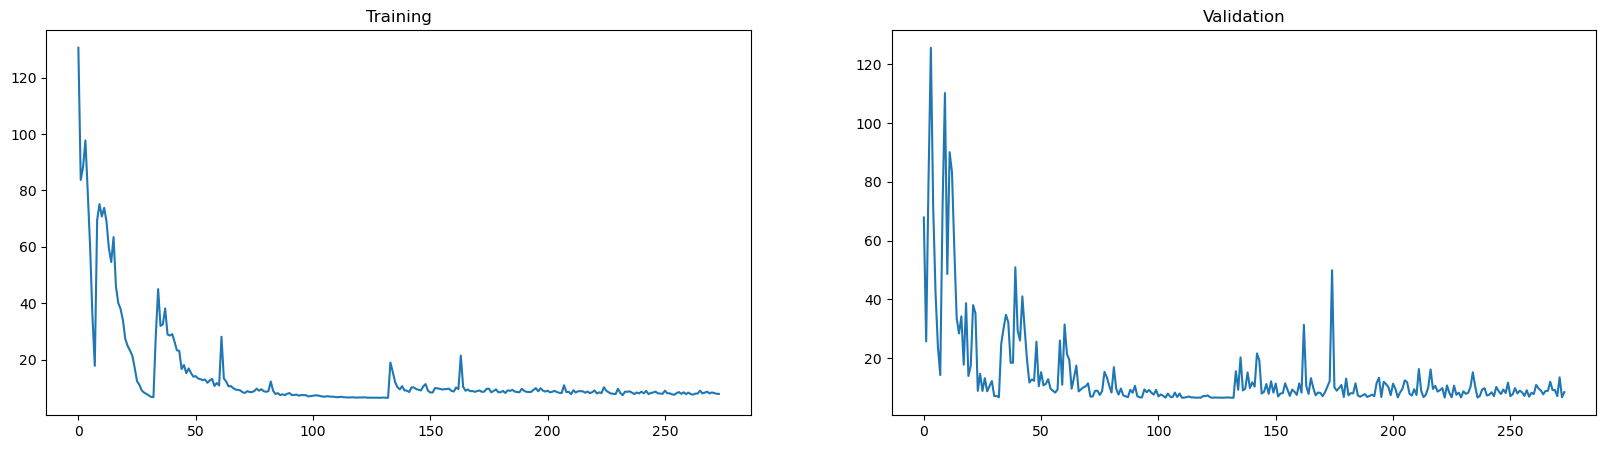

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(train_loss)
axs[0].set_title("Training")
axs[1].plot(valid_loss)
axs[1].set_title("Validation")

plt.show()

# Fail...
Performance is very bad

# Split each county to predict

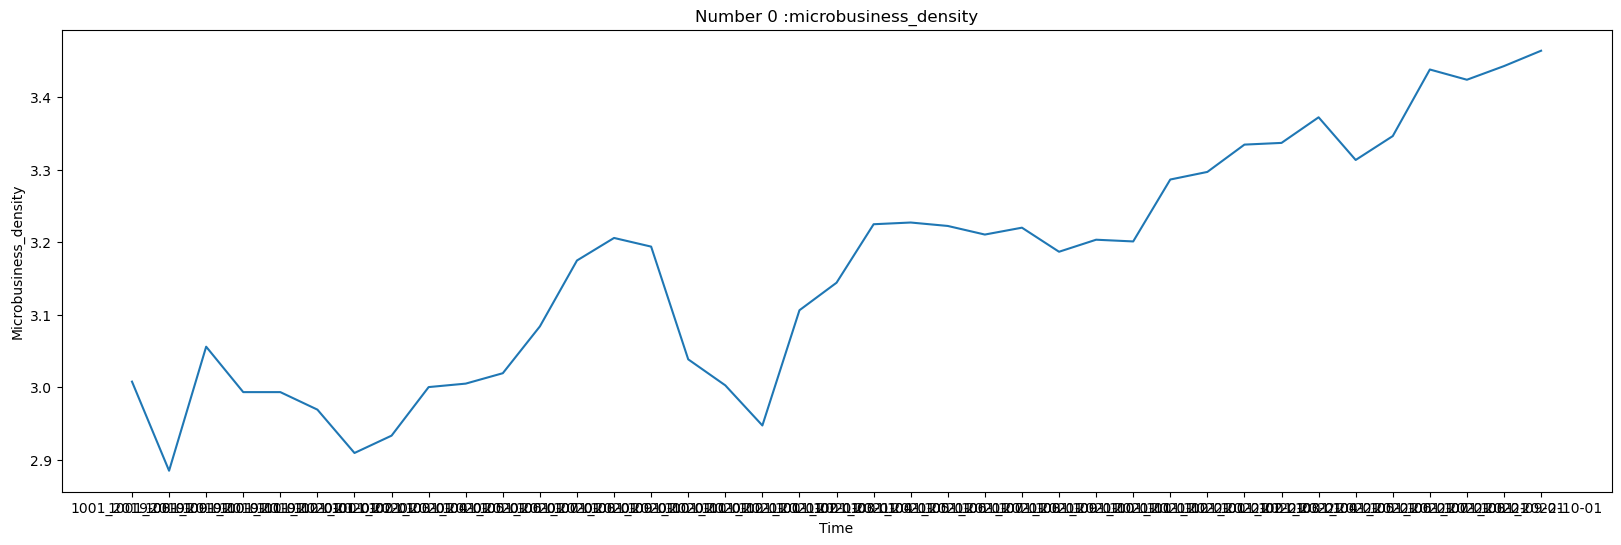

In [58]:
plt.figure(figsize=(20, 6))
number = 0
plt.plot(data_train[data_train['county_code'] == number]['microbusiness_density'])
plt.title('Number {} :microbusiness_density'.format(number))
plt.xlabel('Time')
plt.ylabel('Microbusiness_density')
plt.show()

In [59]:
data_train.drop('state_mean', axis=1, inplace=True)
data_train.drop('county_code_mean', axis=1, inplace=True)

In [60]:
data_test.drop('state_mean', axis=1, inplace=True)
data_test.drop('county_code_mean', axis=1, inplace=True)

In [61]:
def same_seed(seed):
    # Fixes random number generator seeds for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # same data
    np.random.seed(seed)
    torch.manual_seed(seed) # torch+CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # torch+GPU

In [62]:
# x: feature, y: target; if y is None -> predict
class SplitCounty_Dataset(Dataset):
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)
        
    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]
        
    def __len__(self):
        return len(self.x)

In [63]:
class Split_Model(nn.Module):
    def __init__(self, input_dim):
        super(Split_Model, self).__init__()
        n_hidden = input_dim
        self.layers = nn.Sequential(
            nn.Linear(input_dim, n_hidden),
#             nn.LeakyReLU(0.1),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )
    
    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

In [64]:
class Sampe(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_pred, y_true):
        num = torch.abs(torch.sub(y_true, y_pred))
        denom = torch.add(torch.abs(y_true), torch.abs(y_pred))
        denom = torch.div(denom,200.0)
        val = torch.div(num,denom)
        # val = torch.where(denom == 0.0, 0.0, val) this is worng
        val = torch.where(denom == 0.0, torch.tensor(0, dtype=denom.dtype).to(device), val)
        return torch.mean(val)

In [65]:
def trainer(train_loader, model, county_id):
    
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=split_config['learning_rate']*40, weight_decay=5e-4)
    # loss
    criterion = Sampe()
    
    # https://ithelp.ithome.com.tw/articles/10277623?sc=iThelpR
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=2, eta_min=0)
    
    # Create directory of saving models.
    if not os.path.isdir('./models'):
        os.mkdir('./models') 
        
    n_epochs, best_loss, step, early_stop_count = split_config['n_epochs'], math.inf, 0, 0        
    
    for epoch in range(n_epochs):
        model.train() # train model
        loss_record = []
        
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device) 
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            step += 1
            loss_record.append(loss.detach().item())
            scheduler.step()
            
            
        mean_train_loss = sum(loss_record)/len(loss_record)
        
        
        if epoch == n_epochs - 1:
            if best_loss < 1.5:
                print('Epoch [{}/{}], Saving model with loss {:.3f}...'.format(epoch+1, n_epochs, best_loss))
            else:
                print('Epoch [{}/{}], loss {:.3f} is too large, so we abandon!\n'.format(epoch+1, n_epochs, best_loss))
            return best_loss
        if mean_train_loss < best_loss:
            best_loss = mean_train_loss
            torch.save(model.state_dict(), split_config['save_path']) # Save your best model
            early_stop_count = 0
        else: 
            early_stop_count += 1
            
        if early_stop_count >= split_config['early_stop']:
            print('\nModel is not improving, halt')
            if best_loss < 1:
                print('Epoch [{}/{}], Saving model with loss {:.3f}...'.format(epoch+1, n_epochs, best_loss))
            else:
                print('Epoch [{}/{}], loss {:.3f} is too large, so we abandon!\n'.format(epoch+1, n_epochs, best_loss))
            return best_loss

In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
split_config = {
    'seed': 416,      # Your seed number, you can pick your lucky number. :
    'n_epochs': 1000,     # Number of epochs.            
    'learning_rate': 1e-4,       
    'early_stop': 650,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/split_model.ckpt'  # Your model will be saved here.
}

In [67]:
# 0~3135
county_idx = []
for i in range(3135):
    county_idx.append(i)

# 每個county有幾筆資料量
train_county_len = []
test_county_len = []
for i in county_idx:
    train_county_len.append(len(data_train[data_train['county_code'] == i]))   
for i in county_idx:
    test_county_len.append(len(data_test[data_test['county_code'] == i]))   

test_county_list = data_test['county_code'].unique()

In [68]:
def split_train(start_idx, end_idx):
    temp_preds = []
    for code in county_idx[start_idx:end_idx]:
        if code in test_county_list:
            print("### County code : No.{}  is training".format(code))

            county = data_train[data_train['county_code'] == code]

            county.drop('county_code', axis=1, inplace=True)

            same_seed(split_config['seed'])

            county = county.values

            print(f"""train_data size: {county.shape} """)

            x_train, y_train = county[:,:-1], county[:, -1]


            train_dataset = SplitCounty_Dataset(x_train, y_train)
            train_loader = DataLoader(train_dataset, batch_size=int(train_county_len[code]/5), shuffle=False, pin_memory=True)

            model = Split_Model(input_dim=x_train.shape[1]).to(device)
            best_loss = trainer(train_loader, model, code)

            # predict
            test_df = data_test[data_test['county_code'] == code]
            test_df.drop('county_code', axis=1, inplace=True)
            x_test = test_df.values
            
            if best_loss < 1.5:
                model.load_state_dict(torch.load(split_config['save_path']))

                test_dataset = SplitCounty_Dataset(x_test)
                test_loader = DataLoader(test_dataset, batch_size=test_county_len[code], shuffle=False, pin_memory=True)

                model.eval()
                print("### County code : No.{}  is predicting\n".format(code))
                preds = []
                for x in test_loader:
                    x = x.to(device)                        
                    with torch.no_grad():                   
                        pred_active = model(x) 
                        preds.append(pred_active.detach().cpu())
                preds = torch.cat(preds, dim=0).numpy()
                for i in list(preds):
                    all_pred.append(str(float(i)))
            
            # if performance is bad, add last value as prediction
            else:
                value = data_train[data_train['county_code'] == code][-1:]['microbusiness_density'].values[0]
                test_len = len(test_df)
                for i in range(test_len):
                    all_pred.append(str(value))

            
    for i in range(len(all_pred)):
        all_pred[i] = all_pred[i] + '\n'

In [69]:
def wirte_txt(mode, output_list):
    if mode == 'w':
        with open('output.txt', 'w') as f:
            f.writelines(output_list)
    elif mode == 'a':
        with open('output.txt', 'a') as f:
            f.writelines(output_list)

In [70]:
# example 
all_pred = []
split_train(0, 10)

# start training (about 9 hours)
# all_pred = []
# split_train(0, 500)
# wirte_txt('w', all_pred)

# split_train(500, 1000)
# wirte_txt('a', all_pred)

# split_train(1000, 1500)
# wirte_txt('a', all_pred)

# split_train(1500, 2000)
# wirte_txt('a', all_pred)

# split_train(2000, 2500)
# wirte_txt('a', all_pred)

# split_train(2500, len(county_idx))
# wirte_txt('a', all_pred)

### County code : No.0  is training
train_data size: (39, 10) 


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch [1000/1000], Saving model with loss 0.173...
### County code : No.0  is predicting

### County code : No.1  is training
train_data size: (39, 10) 
Epoch [1000/1000], Saving model with loss 0.531...
### County code : No.1  is predicting

### County code : No.2  is training
train_data size: (39, 10) 
Epoch [1000/1000], Saving model with loss 0.125...
### County code : No.2  is predicting

### County code : No.3  is training
train_data size: (39, 10) 
Epoch [1000/1000], Saving model with loss 0.160...
### County code : No.3  is predicting

### County code : No.4  is training
train_data size: (39, 10) 
Epoch [1000/1000], Saving model with loss 0.154...
### County code : No.4  is predicting

### County code : No.5  is training
train_data size: (39, 10) 
Epoch [1000/1000], Saving model with loss 0.229...
### County code : No.5  is predicting

### County code : No.6  is training
train_data size: (39, 10) 
Epoch [1000/1000], Saving model with loss 0.071...
### County code : No.6  is pred

In [71]:
# download
# path_output = 'output.txt'
# ans = []
# with open(path_output) as f:
#     for line in f.readlines():
#         ans.append(float(line.split('\n')[0]))     
    
# already predict
path_output = '/kaggle/input/output/output.txt'
ans = []
with open(path_output) as f:
    for line in f.readlines():
        ans.append(float(line.split('\n')[0]))    

ordered_ans = []
for i in range(len(data_test)):
    ordered_ans.append(0.0)
               
new_idx = []
for i in range(3135):
    new_idx.append(i)

count = 0
for i in new_idx:
    for j in list(data_test[data_test['county_code'] == i].index):
        ordered_ans[j] = ans[count]
        count += 1


t = pd.read_csv(os.path.join(path, 'test.csv'), index_col='row_id')
t['microbusiness_density'] = ordered_ans
sub = pd.DataFrame(t['microbusiness_density'])
sub

,microbusiness_density
row_id,
1001_2022-11-01,3.480612
1003_2022-11-01,8.418086
1005_2022-11-01,1.221487
1007_2022-11-01,1.280814
1009_2022-11-01,1.852245
...,...
56037_2023-06-01,2.778225
56039_2023-06-01,25.547062
56041_2023-06-01,3.847564


In [72]:
# sort by every county
c_name = []
order_idx = []
for i in list(sub.index):
    if i.split('_')[0] not in c_name:
        c_name.append(i.split('_')[0])
for i in c_name:
    for j in list(sub.index):
        if j.split('_')[0] == i:
            order_idx.append(j)
# order_idx
sub2 = sub.reindex(order_idx)
sub2

,microbusiness_density
row_id,
1001_2022-11-01,3.480612
1001_2022-12-01,3.499720
1001_2023-01-01,3.463615
1001_2023-02-01,3.482724
1001_2023-03-01,3.501832
...,...
56045_2023-02-01,1.848058
56045_2023-03-01,1.848162
56045_2023-04-01,1.848265


In [73]:
# DataFrame to csv
sub.to_csv('submission.csv')